In [2]:
import codecs
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
import sklearn
%matplotlib inline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from bootstrap_code.bootstrap_routines import *
import nltk
import sys
import string
sys.path.append('../')
from my_data_utils import load_liar_data, load_kaggle_data, load_FNC_data, load_BS_data

In [3]:
path = "data/"

# FCE

In [3]:
#prof_entire_docs_students = codecs.open(path+"proficiency_entire_docs.txt", "r", "utf-8").read().split("\n")
#docscore_entire_docs_students = codecs.open(path+"docscore_entire_docs.txt", "r", "utf-8").read().split("\n")
#first_lang = codecs.open(path+"firstlang_entire_docs.txt", "r", "utf-8").read().split("\n")

pr_entire = [float(l.strip().split()[0]) for l in open(path+"proficiency_entire_docs.txt",'r').readlines()]
Grades = pr_entire
ID_entire = [l.strip().split()[1] for l in open(path+"proficiency_entire_docs.txt",'r').readlines()]
docscore_entire = [l.strip().split()[0] for l in open(path+"docscore_entire_docs.txt",'r').readlines()]
docscore_entire = [float(i.strip("T")) for i in docscore_entire]
student_preds_entire = pd.read_csv(path+'liar_student_preds_softmax_entire_docs-2.txt', sep=' ', names=['conf_0', 'conf_1'], header=None)
M = np.genfromtxt("data/liar_student_preds_softmax_entire_docs-2.txt", delimiter=' ',skip_header=0)
first_lang_entire = [l.strip().split()[0] for l in open(path+"firstlang_entire_docs.txt",'r').readlines()]

### to change from liar to other dataset 

In [4]:
#student_preds_entire = pd.read_csv(path+'FNC_student_preds_softmax_entire_docs.txt', sep=' ', names=['conf_0', 'conf_1'], header=None)
#M = np.genfromtxt("data/FNC_student_preds_softmax_entire_docs.txt", delimiter=' ',skip_header=0)

In [5]:


preds_entire = [1 if i >0.5 else 0 for i in student_preds_entire.conf_1]
temp_entire = {"ID": ID_entire, "proficiency_score": pr_entire, "docscore":docscore_entire, "pred":preds_entire, "first_lang":first_lang_entire}
temp_entire_df = pd.DataFrame(temp_entire)
df_entire = pd.concat([temp_entire_df, student_preds_entire], axis=1)

In [12]:
print(len(df_entire))
print(df_entire.first_lang.unique())
for i in df_entire.first_lang.unique():
    print(i, len(df_entire[df_entire.first_lang==i].ID.unique()))
    

194
['Spanish' 'Japanese' 'Greek' 'Catalan' 'Russian' 'Polish' 'French'
 'Korean' 'Thai' 'Chinese' 'Italian' 'German' 'Turkish' 'Portuguese']
Spanish 10
Japanese 7
Greek 6
Catalan 8
Russian 6
Polish 4
French 12
Korean 8
Thai 8
Chinese 9
Italian 5
German 9
Turkish 4
Portuguese 1


In [7]:
df_entire_t = df_entire[(df_entire.conf_1>0.5)]
#df_entire_t = df_entire_t[(df_entire_t.docscore>2)]
print(stats.spearmanr(df_entire_t["docscore"], df_entire_t["conf_1"]))

SpearmanrResult(correlation=-0.18656321135866874, pvalue=0.035715789279599515)


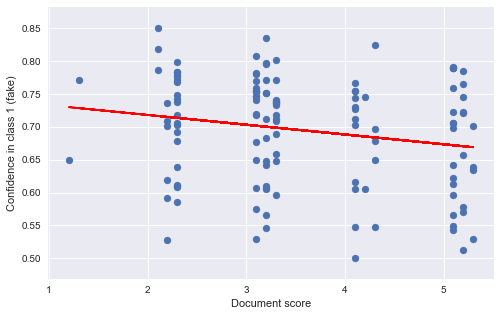

In [8]:
fig, ax = plt.subplots(figsize=(8,5))
ax.scatter(df_entire_t["docscore"], df_entire_t["conf_1"])

z = np.polyfit(df_entire_t["docscore"], df_entire_t["conf_1"], 1)
p = np.poly1d(z)
ax.plot(df_entire_t["docscore"],p(df_entire_t["docscore"]), color="r", linestyle="solid")
r = r'$\rho$'
#plt.title(r+"=-0.187, p=0.0357")
plt.ylabel("Confidence in class 1 (fake)")
plt.xlabel("Document score")

plt.savefig("conf1_docsore_scatter.png", dpi=100)

In [9]:
#stats.shapiro(df_entire_t["docscore"])

In [10]:
#fig, ax = plt.subplots(figsize=(8,5))
#ax.hist(df_entire_t["docscore"], bins=len(df_entire_t["docscore"]))

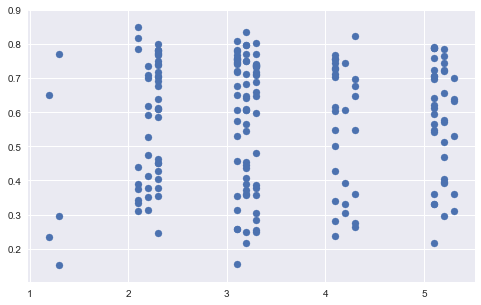

In [11]:
fig, ax = plt.subplots(figsize=(8,5))
ax.scatter(df_entire["docscore"], df_entire["conf_1"])
#plt.title("correlation=-0.18656321135866874, pvalue=0.035715789279599515")


In [12]:
entire_grouped_on_ID = df_entire.groupby(['ID', 'proficiency_score', "first_lang"], as_index=False).mean()
#entire_grouped_on_ID.proficiency_score = entire_grouped_on_ID.proficiency_score/2
#entire_grouped_on_ID = entire_grouped_on_ID[(entire_grouped_on_ID.proficiency_score>22)] # no grades below 22
entire_grouped_on_ID.head()

,ID,proficiency_score,first_lang,docscore,pred,conf_0,conf_1
0,TE1*0100*2001*01,30.0,French,3.75,0.5,0.425301,0.574699
1,TE10*0100*2001*01,26.0,Chinese,3.20,0.5,0.588776,0.411224
2,TE11*0100*2001*01,23.0,Italian,2.70,0.5,0.407784,0.592216
3,TE12*0100*2001*01,26.0,Japanese,3.65,1.0,0.280753,0.719247
4,TE13*0100*2001*01,26.0,Italian,3.30,1.0,0.372626,0.627374


In [13]:
entire_grouped_on_ID[entire_grouped_on_ID.ID=="TE23*0100*2001*01"]

,ID,proficiency_score,first_lang,docscore,pred,conf_0,conf_1
15,TE23*0100*2001*01,21.0,Spanish,2.65,0.5,0.529466,0.470534


SpearmanrResult(correlation=0.0321449716529837, pvalue=0.7546089952495417)


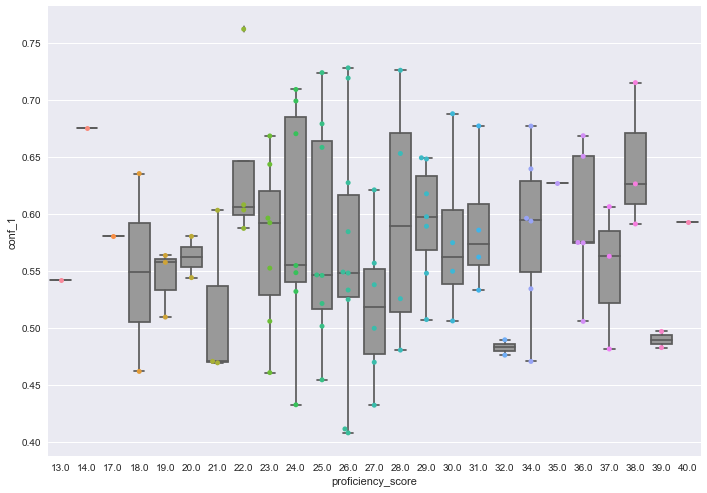

In [14]:
print(stats.spearmanr(entire_grouped_on_ID["proficiency_score"], entire_grouped_on_ID["conf_1"]))

sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.boxplot(x="proficiency_score", y="conf_1",data=entire_grouped_on_ID, color="0.6", )
sns.swarmplot(x="proficiency_score", y="conf_1", data=entire_grouped_on_ID)


#plt.savefig("figname.png", dpi=300) # dpi=resolution

In [15]:
def difference_plot(Grades, M):
    #Grades=[l.strip().split()[0] for l in open("data/proficiency_entire_docs.txt",'r').readlines()]
    #M = np.genfromtxt("data/student_preds_softmax_entire_docs-2.txt", delimiter=' ',skip_header=0)
    
    A,B=[],[]
    M_normed = M
    for i in range(len(Grades)):
        A.append(M[i,1])
        B.append(float(Grades[i]))
    

    even=True
    A_,B_=[],[]
    for (a,b) in zip(A,B):
        if even:
            (prev_a,prev_b)=(a,b)
            even=False
        else:
            if b in range(20,40):
                A_.append(abs(a-prev_a))
                B_.append(b)
            even=True
    #print(A_)
    #print(B_)
    print("diff:"+str(stats.spearmanr(A_,B_)))
    plt.scatter(B_,A_)

diff:SpearmanrResult(correlation=0.10064206522633412, pvalue=0.3508309089294942)


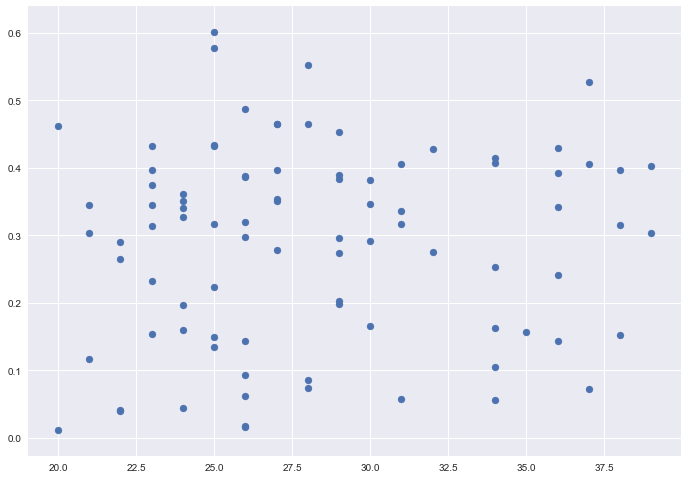

In [16]:
difference_plot(Grades, M)

In [17]:
def boxplot_firstlang(conf_score, prof_score, firstlang):
    sns.set_style('white')
    sns.set(rc={'figure.figsize':(11.7,8.27)})
    sns.set_context('paper', font_scale=1.4)
    author_and_lang = pd.DataFrame(
    {'conf_fake': conf_score,
     'score': prof_score,
     'first_lang': firstlang
    })
    ax = sns.boxplot(x="score", y="conf_fake",data=author_and_lang, color="white")#hue="first_lang"
    ax = sns.swarmplot(x="score", y="conf_fake", data=author_and_lang,hue="first_lang", palette="coolwarm")
    # iterate over boxes
    for i,box in enumerate(ax.artists):
        box.set_edgecolor('black')
        box.set_facecolor('white')

        # iterate over whiskers and median lines
        for j in range(6*i,6*(i+1)):
             ax.lines[j].set_color('black')
    ax.legend(title="First language",loc='center', bbox_to_anchor=(1.15, 0.5))
    plt.savefig("FCE_boxplot_warm.png", dpi=100, bbox_inches='tight')

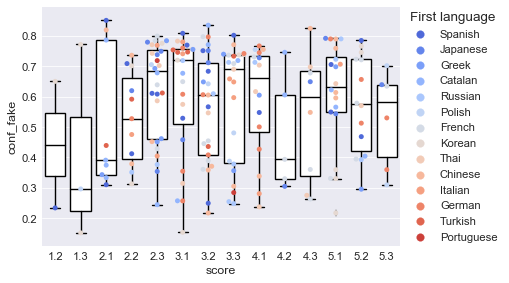

In [18]:
boxplot_firstlang(list(student_preds_entire.conf_1), docscore_entire, first_lang_entire)

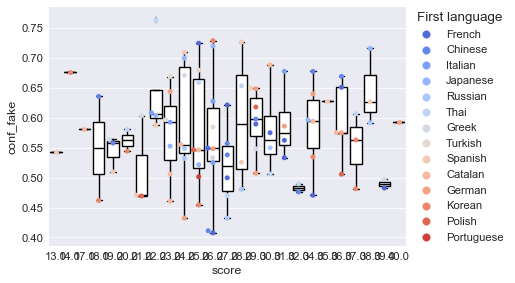

In [273]:
entire_grouped_on_ID
boxplot_firstlang(list(entire_grouped_on_ID.conf_1), entire_grouped_on_ID.proficiency_score, entire_grouped_on_ID.first_lang)

In [274]:
#sns.boxplot(df_entire.docscore, df_entire.conf_1)

In [275]:
diff_score = []
df_entire.iloc[0].ID
prev_id = None
grade = []
firstlang= []

for i in range(len(df_entire)):
    curr_id = df_entire.iloc[i].ID
    if curr_id != prev_id:
        curr_score = df_entire.iloc[i].conf_1
    else:
        if df_entire.iloc[i].proficiency_score >20:
            next_score = df_entire.iloc[i].conf_1
            diff_score.append(abs(curr_score-next_score))
            grade.append(df_entire.iloc[i].proficiency_score)
            firstlang.append(df_entire.iloc[i].first_lang)
    prev_id = curr_id
        

In [276]:
len(diff_score)

87

SpearmanrResult(correlation=0.07588496945665975, pvalue=0.48481543168172947)


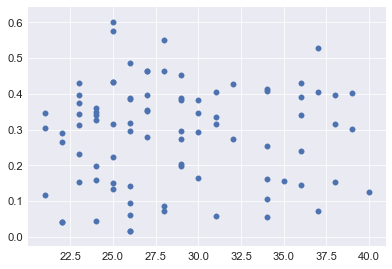

In [277]:
print(stats.spearmanr(grade,diff_score))
plt.scatter(grade,diff_score)

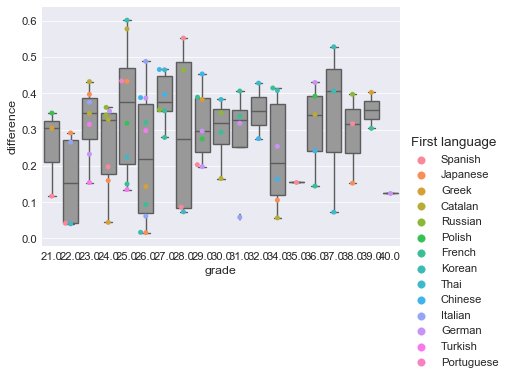

In [278]:

author_and_lang = pd.DataFrame(
    {'difference': diff_score,
     'grade': grade,
     'first language': firstlang
    })
sns.boxplot(x="grade", y="difference",data=author_and_lang, color="0.6")#hue="first_lang"
sns.swarmplot(x="grade", y="difference", data=author_and_lang,hue="first language")
plt.legend(title="First language",loc='upper left', bbox_to_anchor=(1, 0.5))

In [279]:
def correlate_prof_pred(dataframe, score="docscore"):
    """Correlate profiency score with predictions for each language"""
    
    print("avg confidence of class 1 / fake",np.round(dataframe.conf_1.mean()*100, 2))
    #lang = pd.crosstab(fce['first_lang'],fce.conf_0).apply(lambda r: r/r.sum(), axis=1)
    corr = dataframe.groupby('first_lang').apply(lambda x: stats.spearmanr(x.conf_1, x[score]))
    grouped = dataframe.groupby('first_lang').mean()
    #print(grouped)
    grouped['r'] = corr.apply(lambda x: np.round(x[0],3))
    grouped['p'] = corr.apply(lambda x: np.round(x[1],3))
            
    #make latex table
    #latexdf=dataframe.groupby('first_lang').mean().loc[:,['conf_0' ]].sort_values(by='conf_0', ascending=False)
    latexdf = grouped.loc[:,['conf_1', score, 'r', 'p']].sort_values(by='conf_1', ascending=False)
    latexdf['n'] = dataframe.groupby('first_lang')[score].count()#adding support for each first_lang
    print(latexdf['n'].sum())
    latexdf.conf_1 = np.round(latexdf.conf_1*100,2)
    latexdf.dropna(inplace=True)
    print(latexdf[['conf_1', 'r', 'n', 'p']].to_latex())

In [280]:
correlate_prof_pred(df_entire, score="docscore")

avg confidence of class 1 / fake 57.48
194
\begin{tabular}{lrrrr}
\toprule
{} &  conf\_1 &      r &   n &      p \\
first\_lang &         &        &     &        \\
\midrule
Turkish    &   63.21 &  0.244 &   8 &  0.560 \\
Japanese   &   62.96 & -0.051 &  14 &  0.862 \\
Italian    &   60.59 & -0.086 &  10 &  0.812 \\
Spanish    &   59.73 &  0.142 &  20 &  0.551 \\
Thai       &   59.07 & -0.392 &  16 &  0.133 \\
German     &   57.47 &  0.084 &  18 &  0.741 \\
Greek      &   56.92 & -0.050 &  12 &  0.878 \\
Chinese    &   56.87 &  0.245 &  18 &  0.328 \\
Catalan    &   56.30 &  0.223 &  16 &  0.406 \\
French     &   55.53 & -0.249 &  24 &  0.241 \\
Korean     &   55.53 &  0.114 &  16 &  0.674 \\
Polish     &   53.47 &  0.181 &   8 &  0.668 \\
Russian    &   52.23 &  0.431 &  12 &  0.161 \\
\bottomrule
\end{tabular}



In [281]:
#plt.scatter(df_entire[df_entire.first_lang=="Russian"].docscore, df_entire[df_entire.first_lang=="Russian"].conf_1)

In [282]:
correlate_prof_pred(entire_grouped_on_ID, score="docscore")

avg confidence of class 1 / fake 57.48
97
\begin{tabular}{lrrrr}
\toprule
{} &  conf\_1 &      r &   n &      p \\
first\_lang &         &        &     &        \\
\midrule
Turkish    &   63.21 & -0.200 &   4 &  0.800 \\
Japanese   &   62.96 &  0.214 &   7 &  0.645 \\
Italian    &   60.59 &  0.600 &   5 &  0.285 \\
Spanish    &   59.73 &  0.455 &  10 &  0.187 \\
Thai       &   59.07 & -0.407 &   8 &  0.317 \\
German     &   57.47 &  0.209 &   9 &  0.589 \\
Greek      &   56.92 & -0.714 &   6 &  0.111 \\
Chinese    &   56.87 &  0.385 &   9 &  0.306 \\
Catalan    &   56.30 &  0.467 &   8 &  0.243 \\
French     &   55.53 & -0.152 &  12 &  0.638 \\
Korean     &   55.53 &  0.108 &   8 &  0.799 \\
Polish     &   53.47 &  0.400 &   4 &  0.600 \\
Russian    &   52.23 &  0.464 &   6 &  0.354 \\
\bottomrule
\end{tabular}



In [283]:
correlate_prof_pred(df_entire_t, score="docscore")

avg confidence of class 1 / fake 69.5
127
\begin{tabular}{lrrrr}
\toprule
{} &  conf\_1 &      r &   n &      p \\
first\_lang &         &        &     &        \\
\midrule
Korean     &   73.58 &  0.220 &  10 &  0.541 \\
Russian    &   71.08 &  0.638 &   6 &  0.173 \\
Chinese    &   71.04 & -0.168 &  11 &  0.622 \\
French     &   70.58 & -0.467 &  13 &  0.107 \\
Greek      &   70.30 & -0.432 &   7 &  0.333 \\
Polish     &   70.08 &  0.000 &   4 &  1.000 \\
Catalan    &   70.02 & -0.599 &  10 &  0.067 \\
Italian    &   69.97 & -0.674 &   7 &  0.097 \\
Japanese   &   69.97 & -0.194 &  11 &  0.568 \\
Turkish    &   69.69 &  0.577 &   6 &  0.231 \\
Spanish    &   68.48 & -0.173 &  15 &  0.538 \\
Thai       &   66.33 & -0.377 &  13 &  0.204 \\
German     &   65.67 & -0.119 &  13 &  0.698 \\
\bottomrule
\end{tabular}



In [284]:
df_entire[["docscore","proficiency_score","conf_1", "conf_0"]].corr(method="spearman")

,docscore,proficiency_score,conf_1,conf_0
docscore,1.000000,0.870571,-0.011030,0.011030
proficiency_score,0.870571,1.000000,-0.012265,0.012265
conf_1,-0.011030,-0.012265,1.000000,-1.000000
conf_0,0.011030,0.012265,-1.000000,1.000000


In [285]:
def corr_with_p_value(df):
    df_corr = pd.DataFrame() # Correlation matrix
    df_p = pd.DataFrame()  # Matrix of p-values
    df_all = pd.DataFrame()
    for x in df.columns:
        for y in df.columns:
            corr = stats.spearmanr(df[x], df[y])
            df_corr.loc[x,y] = np.round(corr[0],4)
            df_p.loc[x,y] = np.round(corr[1],4)
            df_all.loc[x,y] = str(np.round(corr[0],4))+", p="+str(np.round(corr[1],4))
    return df_corr, df_p, df_all

#df_entire[["docscore","proficiency_score","conf_1", "conf_0"]].corr(method="spearman")
df_corr, df_p, df_all = corr_with_p_value(df_entire[["conf_1", "conf_0","docscore","proficiency_score"]])
df_all.drop(["conf_0", "conf_1"], inplace=True)
print(df_all.drop(["docscore", "proficiency_score"], axis=1).to_latex())

\begin{tabular}{lll}
\toprule
{} &             conf\_1 &            conf\_0 \\
\midrule
docscore          &   -0.011, p=0.8787 &   0.011, p=0.8787 \\
proficiency\_score &  -0.0123, p=0.8652 &  0.0123, p=0.8652 \\
\bottomrule
\end{tabular}



# Trustpilot

In [46]:
BS_preds = pd.read_csv("BS_learner_data_preds/BS_TP_all_vs_us_preds.txt", sep=' ', names=['conf_0', 'conf_1'], header=None)
BS_labels = pd.read_csv("BS_learner_data_preds/BS_TP_all_vs_us_labels.txt", sep=' ', names=['lang'], header=None) 

In [47]:
BS_all_vs_us = pd.concat([BS_labels,BS_preds], axis=1)

In [48]:
BS_all_vs_us["conf_1"].var()

0.0832627001537372

In [68]:
def autolabel(rects,ax, labels):
    #for i in labels
    for idx, rect in enumerate(rects):
        height = rect.get_height()
        ax.annotate('{}%'.format(labels[idx]),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=14)

def TP_analysis_barplot(trainingdata):
    learnerdatapath = trainingdata+"_learner_data_preds/"
    languages = ["da", "de", "es", "fr", "it", "nl", "se"]
    lang_fake_counts = []
    lang_fake_percent = []
    us_fake_counts = []
    us_fake_percent = []
    x = np.arange(len(languages))
    for i in languages:
        preds = pd.read_csv(learnerdatapath+trainingdata+"_"+i+"_vs_us_preds.txt", sep=' ', names=['conf_0', 'conf_1'], header=None)
        labels = pd.read_csv(learnerdatapath+trainingdata+"_"+i+"_vs_us_labels.txt", sep=' ', names=['lang'], header=None)
        df = pd.concat([labels,preds], axis=1)
        df_fake = df[(df.conf_1>0.5)]
        count_lang = len(df_fake[(df_fake.lang==i)])
        percent_lang = count_lang/len(df[df.lang==i])*100
        count_us = len(df_fake[(df_fake.lang=="us")])
        percent_us = count_us/len(df[df.lang=="us"])*100
        lang_fake_counts.append(count_lang)
        us_fake_counts.append(count_us)
        lang_fake_percent.append(np.round(percent_lang,1))
        us_fake_percent.append(np.round(percent_us,1))
    
    width = 0.42  # the width of the bars

    fig, ax = plt.subplots(figsize=(15,6))
    rects1 = ax.bar(x - width/2, lang_fake_counts, width, label="second location")
    rects2 = ax.bar(x + width/2, us_fake_counts, width, label='US')
    ax.set_xticks(x)
    ax.set_xticklabels(languages, fontsize=16)
    ax.legend(fontsize=16)
    plt.ylabel("Count of samples predicted as Fake", fontsize=14)
    print(lang_fake_percent)
    print(us_fake_percent)
    autolabel(rects1,ax, lang_fake_percent)
    autolabel(rects2,ax, us_fake_percent)
    plt.ylim(0,1500)
    plt.savefig(trainingdata+"_TP_barplot.png", dpi=100)
    

[38.6, 28.2, 28.5, 37.2, 29.0, 31.3, 23.2]
[37.6, 33.6, 34.6, 37.2, 32.3, 38.0, 34.5]


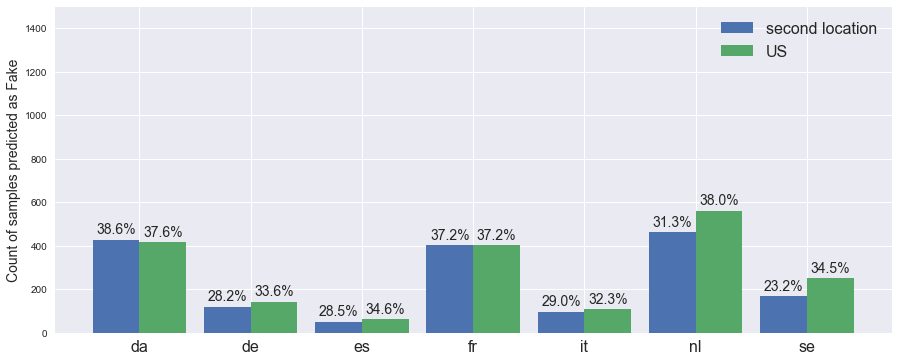

In [69]:
TP_analysis_barplot("liar")

[76.4, 74.4, 77.7, 80.6, 82.6, 74.0, 74.7]
[79.2, 81.2, 79.3, 79.3, 80.5, 80.2, 79.7]


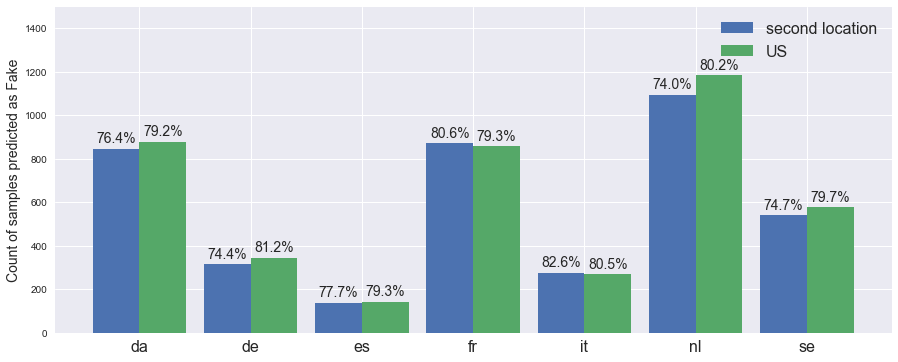

In [70]:
TP_analysis_barplot("BS")

[89.4, 90.1, 88.3, 90.3, 90.4, 86.1, 85.9]
[88.3, 89.6, 88.8, 88.4, 89.8, 88.6, 89.5]


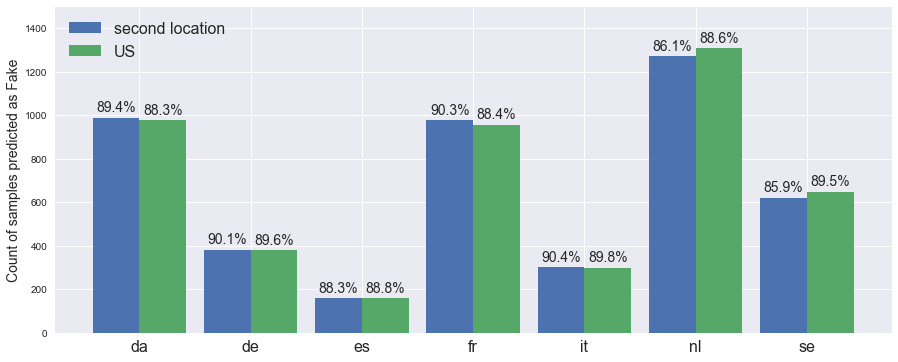

In [71]:
TP_analysis_barplot("kaggle")

[41.4, 40.7, 44.1, 37.9, 46.1, 38.0, 44.3]
[49.3, 48.9, 49.7, 49.4, 48.2, 50.7, 50.8]


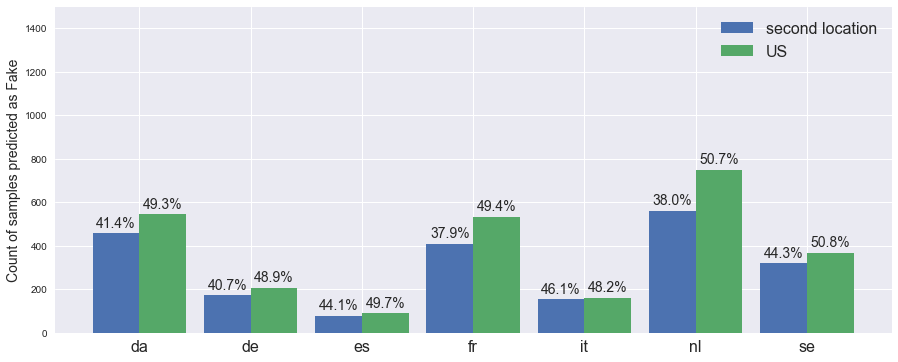

In [72]:
TP_analysis_barplot("FNC")

In [64]:
def TP_analysis_boxplot(trainingdata):
    learnerdatapath = trainingdata+"_learner_data_preds/"
    languages = ["da", "de", "es", "fr", "it", "nl", "se"]
    #lang_fake_counts = []
    #us_fake_counts = []
    #x = np.arange(len(languages))
    fig, axs = plt.subplots(7, figsize=(5,20))
    plt.subplots_adjust(hspace=0.35)
    for index, i in enumerate(languages):
        preds = pd.read_csv(learnerdatapath+trainingdata+"_"+i+"_vs_us_preds.txt", sep=' ', names=['conf_0', 'conf_1'], header=None)
        labels = pd.read_csv(learnerdatapath+trainingdata+"_"+i+"_vs_us_labels.txt", sep=' ', names=['lang'], header=None)
        df = pd.concat([labels,preds], axis=1)
        
        # choose which confidence scores to look at:
        df_fake = df#[(df.conf_1>0.5)] 
        
        count_lang = len(df_fake[(df_fake.lang==i)])
        count_us = len(df_fake[(df_fake.lang=="us")])
        #lang_fake_counts.append(count_lang)
        #us_fake_counts.append(count_us)
        lang_confs = list(df_fake[df_fake.lang==i].conf_1)
        us_confs = list(df_fake[df_fake.lang=="us"].conf_1)
        data = [lang_confs, us_confs]
        axs[index].boxplot(data)
        y = data[0]
        x = np.random.normal(1, 0.04, size=len(y))
        axs[index].plot(x, y, '.', alpha=0.2)
        y = data[1]
        x = np.random.normal(2, 0.04, size=len(y))
        axs[index].plot(x, y, '.', alpha=0.2)
        axs[index].set_xticklabels([i, 'us'], fontsize=16)
        axs[index].set_ylabel("Confidence score")
        
    #rects1 = ax.bar(x - width/2, lang_fake_counts, width, label="second location")
    #rects2 = ax.bar(x + width/2, us_fake_counts, width, label='US')
    #ax.set_xticks(x)
    #ax.set_xticklabels(languages, fontsize=14)
    #ax.legend(fontsize=12)
    #plt.savefig("TP_conf1_boxplots.png", dpi=150)

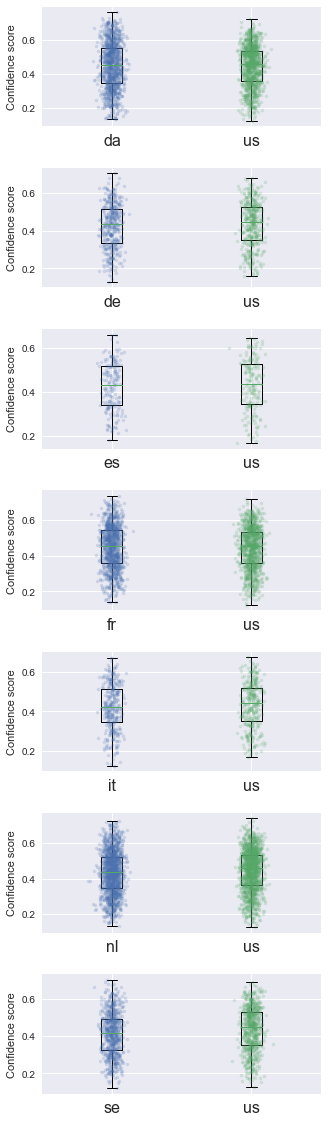

In [67]:
TP_analysis_boxplot("liar")

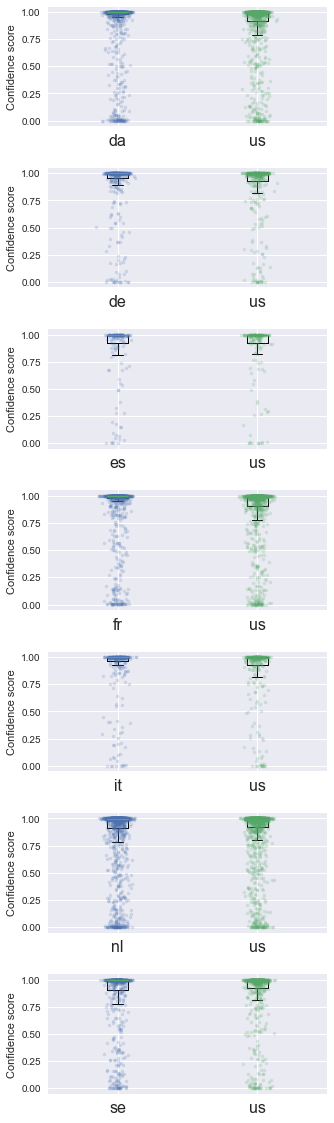

In [65]:
TP_analysis_boxplot("kaggle")

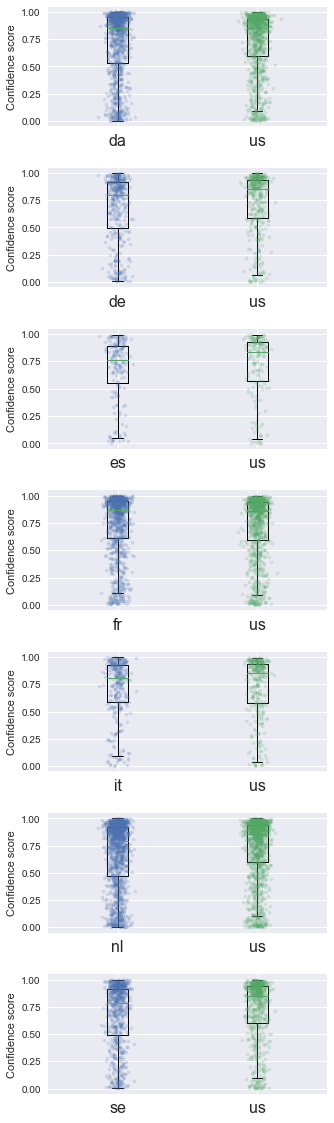

In [60]:
TP_analysis_boxplot("BS")

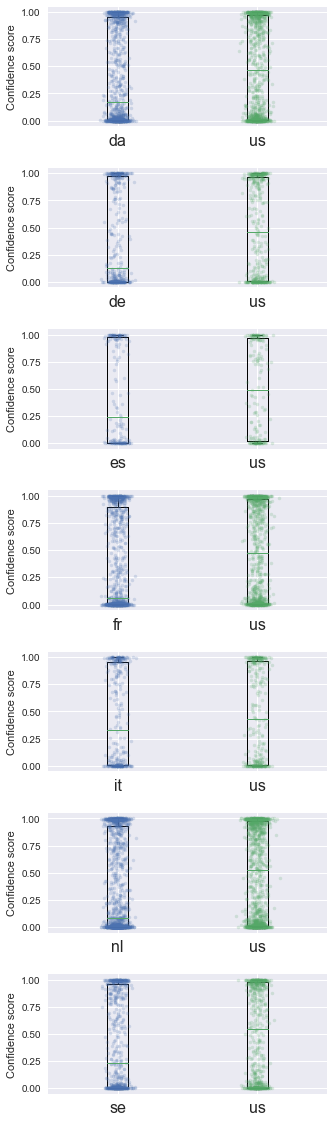

In [61]:
TP_analysis_boxplot("FNC")

In [4]:
# Envestigate langs and US sentences

# loading data functions:

def load_TP_US_sample(datapath, file, n):
    df = pd.read_csv(datapath+file)
    #print("number of reviews not nan:",len(df)-pd.isnull(df["review"]).sum()) # number of actual reviews
    df = df[pd.notnull(df["review"])]
    #print("number of reviews and gender not nan:",len(df)-pd.isnull(df["gender"]).sum())# reviews with gender as well
    df = df[pd.notnull(df["gender"])]
    df = df.sample(n=n, random_state=42)
    return list(df["review"])

def load_TP_data_one_vs_us(datapath, lang_file):
    print("method = one vs US")
    other = codecs.open(datapath+lang_file, "r", "utf-8").read().split("\n")
    other = other[:len(other)-1]
    lab = lang_file[3:5]
    #print(lab, len(other))
    us = load_TP_US_sample(datapath, "TP/TP_US.tmp.csv", len(other))
    data = other+us
    labels = [lab]*len(other)+["us"]*len(us)
    data, labels = shuffle(data,labels, random_state=42)
    return data, labels

def load_TP_data_all_vs_us(path):
    da = codecs.open(path+"TP/da.test.txt", "r", "utf-8").read().split("\n")
    da = da[:len(da)-1]
    de = codecs.open(path+"TP/de.test.txt", "r", "utf-8").read().split("\n")
    de = de[:len(de)-1]
    es = codecs.open(path+"TP/es.test.txt", "r", "utf-8").read().split("\n")
    es = es[:len(es)-1]
    fr = codecs.open(path+"TP/fr.test.txt", "r", "utf-8").read().split("\n")
    fr = fr[:len(fr)-1]
    it = codecs.open(path+"TP/it.test.txt", "r", "utf-8").read().split("\n")
    it = it[:len(it)-1]
    nl = codecs.open(path+"TP/nl.test.txt", "r", "utf-8").read().split("\n")
    nl = nl[:len(nl)-1]
    se = codecs.open(path+"TP/se.test.txt", "r", "utf-8").read().split("\n")
    se = se[:len(se)-1]
    #print("method = all vs US")
    num_us_samples = len(da)+len(de)+len(es)+len(fr)+len(it)+len(nl)+len(se)
    us = load_TP_US_sample(path, "TP/TP_US.tmp.csv", num_us_samples)
    data = da+de+es+fr+it+nl+se+us
    labels = ["da"]*len(da)+["de"]*len(de)+["es"]*len(es)+["fr"]*len(fr)+["it"]*len(it)+["nl"]*len(nl)+["se"]*len(se)+["us"]*len(us)
    data, labels = shuffle(data,labels, random_state=42)
    return data, labels

In [5]:

# make dataframes
# count puncts
def get_TP_dataframes(trainingdata):
    learnerdatapath = trainingdata+"_learner_data_preds/"
    languages = ["da", "de", "es", "fr", "it", "nl", "se"]
    
    lang_files = ["TP/da.test.txt", "TP/de.test.txt", "TP/es.test.txt", "TP/fr.test.txt",
                  "TP/it.test.txt", "TP/nl.test.txt", "TP/se.test.txt"]
    
    dfs = []
    
    for index, i in enumerate(lang_files):
        test, test_lab = load_TP_data_one_vs_us("/Users/Terne/Documents/KU/Speciale/thesis/english_proficiency_experiments/data/", i)
        test = [i.lower() for i in test]
        preds = pd.read_csv(learnerdatapath+trainingdata+"_"+languages[index]+"_vs_us_preds.txt", sep=' ', names=['conf_0', 'conf_1'], header=None)
        labels = pd.read_csv(learnerdatapath+trainingdata+"_"+languages[index]+"_vs_us_labels.txt", sep=' ', names=['lang'], header=None)
        text_df = pd.DataFrame(list(zip(test,test_lab)), columns=["text", "test_lab"])
        df = pd.concat([text_df,labels,preds], axis=1)
        dfs.append(df)
    
    return dfs

def get_all_vs_us_df(trainingdata):
    learnerdatapath = trainingdata+"_learner_data_preds/"
    test, test_lab = load_TP_data_all_vs_us("/Users/Terne/Documents/KU/Speciale/thesis/english_proficiency_experiments/data/")
    test = [i.lower() for i in test]
    preds = pd.read_csv(learnerdatapath+trainingdata+"_TP_all_vs_us_preds.txt", sep=' ', names=['conf_0', 'conf_1'], header=None)
    labels = pd.read_csv(learnerdatapath+trainingdata+"_TP_all_vs_us_labels.txt", sep=' ', names=['lang'], header=None)
    text_df = pd.DataFrame(list(zip(test,test_lab)), columns=["text", "test_lab"])
    df = pd.concat([text_df,labels,preds], axis=1)
    return df

def count_punctuation(df,lang_string):
    sent_punct_count = []
    df = df[df.lang==lang_string].text.apply(lambda x: nltk.word_tokenize(str(x)))
    for i in df:
        sent_punct_count.append(len([p for p in i if p in string.punctuation]))
    return np.mean(sent_punct_count), sent_punct_count

def most_confident(df):
    most_conf1 = df.sort_values(by=["conf_1"],ascending=False)[:100]
    most_conf0 = df.sort_values(by=["conf_0"],ascending=False)[:100]
    return most_conf1, most_conf0

def analysis_all_dfs():
    trainingdatas = ["liar", "kaggle", "BS", "FNC"]
    identifiers = ["da", "de", "es", "fr", "it", "nl", "se"]
    
    for tr in trainingdatas:
        print(tr)
        dfs = get_TP_dataframes(tr)
        TP_all = get_all_vs_us_df(tr)
        #dfs.append(TP_all)
        total_mean_sent_puncts_second_lang = []
        total_mean_sent_puncts_us = []
        
        for index, df in enumerate(dfs):
            print(identifiers[index])
            most_conf1, most_conf0 = most_confident(df)
            sec_lang_most = most_conf1[most_conf1.lang==identifiers[index]]
            us_most = most_conf1[most_conf1.lang=="us"]
            print("count second language:",len(sec_lang_most))
            print("count us",len(us_most))
            print("mean conf1 of most confident in second language:", np.mean(sec_lang_most.conf_1))
            print("mean conf1 of most confident in us:", np.mean(us_most.conf_1))
            
            total_mean_sent_puncts_second_lang.append(count_punctuation(df[df.lang==identifiers[index]],identifiers[index])[0])
            total_mean_sent_puncts_us.append(count_punctuation(df[df.lang=="us"],"us")[0])
            print("most conf_1",most_conf1.iloc[0].text, most_conf1.iloc[0].lang)
            print("most conf_0",most_conf0.iloc[0].text, most_conf0.iloc[0].lang)
            print()
            lang_mean_punct, lang_sent_punct_count = count_punctuation(most_conf1,identifiers[index])
            us_mean_punct, us_sent_punct_count = count_punctuation(most_conf1,"us")
            print("second lang punct", lang_mean_punct)
            print("us punct", us_mean_punct)
            print("second lang mean word length", np.mean(count_word_lengths(most_conf1, identifiers[index])))
            print("us mean word length", np.mean(count_word_lengths(most_conf1, "us")))
            print("second lang mean sentence length", np.mean(sentence_length(most_conf1, identifiers[index])))
            print("us mean sentence length", np.mean(sentence_length(most_conf1, "us")))
            print()
            print()
        #plt.plot(total_mean_sent_puncts_second_lang, label="second language")
        #plt.plot(total_mean_sent_puncts_us, label="us")
        #plt.xticks(np.arange(7),identifiers, size=14)
        #plt.ylabel("Mean punctuation count")
        #plt.legend(fontsize=14)
        #plt.savefig("TP_mean_punctuation_plot.png", dpi=100)
        #plt.show()
        
    
    

In [161]:
analysis_all_dfs()

liar
method = one vs US
method = one vs US
method = one vs US
method = one vs US
method = one vs US
method = one vs US
method = one vs US
da
count second language: 79
count us 21
mean conf1 of most confident in second language: 0.6790841848035402
mean conf1 of most confident in us: 0.6693322317940849
most conf_1 rodes er super god! god service er en kvalitet som rodes i den grad har! da
most conf_0 efter at jeg har fundet siden kigger jeg mindst 1 gang om dagen efter små sjove/brugbare ting, og har da også købt en del nu, specielt iphone udstyr.', 'det tager ca. 20-30 dage for det ligger i postkassen hvilket er helt fint med mig da det er så billigt og med gratis fragt.', 'der er ikke andet at sige end kanon god side der har det meste!' ingen problemer :) us

second lang punct 1.7088607594936709
us punct 2.7142857142857144
second lang mean word length 3.7267112712300565
us mean word length 3.563106796116505
second lang mean sentence length 24.59493670886076
us mean sentence length 19.6

most conf_1 we're molo fans, my kids love the cool designs and i love the quality! i always buy at littlesunflowers because they have the best price and selection! their customer service is very helpful and shipping is fast. i also love the flower credits rewards ; ) es
most conf_0 i did a google search after ordering some swim goggles and running into problems. (the company i ordered from didn't confirm my order or answer their phone when i tried to call them. neither was i able to reach them by skype or e-mail.) my search led me to trustpilot.com, where i found several reviews from people who'd had similar experiences with the company i was dealing with. if i'd known about trust pilot  before ordering my goggles, i could have avoided the hassle. in short, my experience so far has been positive, and i think the site performs a valuable function. es

second lang punct 6.113636363636363
us punct 6.089285714285714
second lang mean word length 3.9202724358974357
us mean word length 4.0241

method = one vs US
method = one vs US
method = one vs US
method = one vs US
method = one vs US
method = one vs US
da
count second language: 76
count us 24
mean conf1 of most confident in second language: 0.9939196305839639
mean conf1 of most confident in us: 0.9928825696309408
most conf_1 s u p e r s e r v i c e da
most conf_0 ­­­­­­­­ ­­­ ­­ ­ ­ ­ ­ ­ ­ ­ ­ ­ ­ ­ ­ ­﻿ ­ ­ ­ ­ ­ ­ ­ ­ ­ ­ ­ ­ ­ ­ ­ ­ ­ ­ ­ ­ ­­­­­­­­ ­­­ ­­ ­ ­ ­ ­ ­ ­ ­ ­ ­ ­ ­ ­ ­﻿ ­ ­ ­ ­ ­ ­ ­ ­ ­ ­ ­ ­ ­ ­ ­ ­ ­ ­ ­ ­ ­­­­­­­­ ­­­ ­­ ­ ­ ­ ­ ­ ­ ­ ­ ­ ­ ­ ­ ­﻿ ­ ­ ­ ­ ­ ­ ­ ­ ­ ­ ­ ­ ­ ­ ­ ­ ­ ­ ­ ­ ­­­­­­­­ ­­­ ­­ ­ ­ ­ ­ ­ ­ ­ ­ ­ ­ ­ ­ ­﻿ ­ ­ ­ ­ ­ ­ ­ ­ ­ ­ ­ ­ ­ ­ ­ ­ ­ ­ ­ ­ ­­­­­­­­ ­­­ ­­ ­ ­ ­ ­ ­ ­ ­ ­ ­ ­ ­ ­ ­﻿ ­ ­ ­ ­ ­ ­ ­ ­ ­ ­ ­ ­ ­ ­ ­ ­ ­ ­ ­ ­ ­­­­­­­­ ­­­ ­­ ­ ­ ­ ­ ­ ­ ­ ­ ­ ­ ­ ­ ­﻿ ­ ­ ­ ­ ­ ­ ­ ­ ­ ­ ­ ­ ­ ­ ­ ­ ­ ­ ­ ­ ­­­­­­­­ ­­­ ­­ ­ ­ ­ ­ ­ ­ ­ ­ ­ ­ ­ ­ ­﻿ ­ ­ ­ ­ ­ ­ ­ ­ ­ ­ ­ ­ ­ ­ ­ ­ ­ ­ ­ ­ ­­­­­­­­ ­­­ ­­ ­ ­ ­ ­ ­ ­ ­ ­ ­ ­ ­ ­ ­﻿ ­ ­ ­ ­ ­ ­ ­ ­ ­ ­ ­ ­ ­ ­ ­ ­ ­ ­ ­ ­ - da

s

method = one vs US
method = one vs US
method = one vs US
method = one vs US
method = one vs US
method = one vs US
da
count second language: 49
count us 51
mean conf1 of most confident in second language: 0.9999166739230253
mean conf1 of most confident in us: 0.9998870071242837
most conf_1 highly recommend!!!!!! designed tee shirt on monday and submitted. within an hour i received a proof, with a recommendation. made a change, received second proof in less than an hour. approved. great email and text communication through out process. received tee shirts on wednesday, one day ahead of scheduled delivery date. design was perfectly printed, front and back. high quality, thick cotton tee shirts. great color! ink was also high quality, thick but not stiff. washes perfectly, no sticking, chipping or peeling. already recommended to everyone who commented on tee shirts!  graphic designer by trade, so i know good quality when i see it. will definitely use again! thank you so much!!!! us
most co

most conf_1 highly recommend!!!!!! designed tee shirt on monday and submitted. within an hour i received a proof, with a recommendation. made a change, received second proof in less than an hour. approved. great email and text communication through out process. received tee shirts on wednesday, one day ahead of scheduled delivery date. design was perfectly printed, front and back. high quality, thick cotton tee shirts. great color! ink was also high quality, thick but not stiff. washes perfectly, no sticking, chipping or peeling. already recommended to everyone who commented on tee shirts!  graphic designer by trade, so i know good quality when i see it. will definitely use again! thank you so much!!!! us
most conf_0 cheap tickets.....een overzichtelijke site, waar je snel het meest voordelige ticket kunt vinden. groot voordeel is dat je geen creditcard nodig hebt om een ticket aan te kunnen schaffen.', 'minpunt vind ik, dat je wel meer moet betalen voor een ticket, als wanneer je rech

In [121]:
liar_TP_all = get_all_vs_us_df("liar")

In [86]:
liar_TP_all.sort_values(by=["conf_1"],ascending=False)[:10]

,text,test_lab,lang,conf_0,conf_1
8877,"love, love, love!! amazing service- would abs...",us,us,0.232825,0.767175
2464,rodes er super god! god service er en kvalitet...,da,da,0.239330,0.760670
4255,i will not recommend to my fellow golfers nor ...,us,us,0.259865,0.740135
1223,rapide sans probleme pas de parking payant et ...,fr,fr,0.262898,0.737102
3711,"a simple, safe way to buy what you need. i fee...",us,us,0.262928,0.737072
4005,a trusted & fair way to sell your old mobile. ...,us,us,0.265235,0.734765
6133,brilluant service will deffently use your serv...,us,us,0.272027,0.727973
2429,vlotte levering van de spullen en ook wat ik e...,nl,nl,0.273624,0.726376
7552,"det er en super fed forretning, med en super g...",da,da,0.275009,0.724991
6146,simple to order and receive pet products. i w...,us,us,0.275824,0.724176


method = one vs US
method = one vs US
method = one vs US
method = one vs US
method = one vs US
method = one vs US
method = one vs US


In [6]:
def sentence_length(df,lang_string):
    sent_lengths = []
    df = df[df.lang==lang_string].text.apply(lambda x: nltk.word_tokenize(str(x)))
    for i in df:
        sent_lengths.append(len(i))
    return sent_lengths

def count_word_lengths(df, lang_string):
    ls = []
    df = df[df.lang==lang_string].text.apply(lambda x: nltk.word_tokenize(str(x)))
    for i in df:
        ls+=i
    lengths = [len(w) for w in ls]
    return lengths

def investigate_distributions(trainingdata, other_analysis=False):
    l = ["da", "de", "es", "fr", "it", "nl", "se"]
    
    
    dfs = get_TP_dataframes(trainingdata)
    
    if other_analysis==True:
        fig, axs = plt.subplots(7,2, figsize=(10,25))
        plt.subplots_adjust(hspace=0.5, wspace=0.35)
        for index, df in enumerate(dfs):
            _, punct_list1 = count_punctuation(df, l[index])
            sns.distplot(punct_list1, label=l[index], ax=axs[index,0])
            _, punct_list2 = count_punctuation(df, "us")
            sns.distplot(punct_list2, label="us",ax=axs[index,0])
            axs[index,0].legend(fontsize=14)
            ci_diff, boot_d1, boot_d2 = bootci_diff(punct_list1,punct_list2, nboot=5000)
            print("{} vs {} punctuation count bootstrap CI:".format(l[index], "us"), ci_diff)
            sns.distplot(boot_d1, label=l[index], ax=axs[index,1])
            sns.distplot(boot_d2, label="us", ax=axs[index,1])
            axs[index,1].legend(fontsize=14)
            axs[index,1].set_xlabel("Punctuation count",fontsize=16)
            axs[index,0].set_xlabel("Punctuation count",fontsize=16)
            axs[index,1].set_ylabel("Density",fontsize=16)
            axs[index,0].set_ylabel("Density",fontsize=16)
            axs[index,0].set_title("Original samples",fontsize=14)
            axs[index,1].set_title("Bootstrapped samples",fontsize=14)
        plt.savefig(trainingdata+"_TP_dists_punctuation.png", dpi=100)
        sns.plt.show()

        print()
        print()
    
        fig2, axs2 = plt.subplots(7,2, figsize=(10,25))
        plt.subplots_adjust(hspace=0.5, wspace=0.35)
        for index, df in enumerate(dfs):
            length1 = sentence_length(df,l[index])
            sns.distplot(length1, label=l[index], ax=axs2[index,0])
            length2 = sentence_length(df,"us")
            sns.distplot(length2, label="us", ax=axs2[index,0])
            axs2[index,0].legend(fontsize=14)
            ci_diff, boot_d1, boot_d2 = bootci_diff(length1,length2, nboot=5000)
            print("{} vs {} sentence length bootstrap CI:".format(l[index], "us"), ci_diff)
            sns.distplot(boot_d1, label=l[index], ax=axs2[index,1])
            sns.distplot(boot_d2, label="us", ax=axs2[index,1])
            axs2[index,1].legend(fontsize=14)
            axs2[index,1].set_xlabel("Sentence lengths",fontsize=16)
            axs2[index,0].set_xlabel("Sentence lengths",fontsize=16)
            axs2[index,1].set_ylabel("Density",fontsize=16)
            axs2[index,0].set_ylabel("Density",fontsize=16)
            axs2[index,0].set_title("Original samples",fontsize=14)
            axs2[index,1].set_title("Bootstrapped samples",fontsize=14)
        plt.savefig(trainingdata+"_TP_dists_sentlength.png", dpi=100)
        sns.plt.show()

        print()
        print()
    
    
        fig3, axs3 = plt.subplots(7,2, figsize=(10,25))
        plt.subplots_adjust(hspace=0.5, wspace=0.35)
        for index, df in enumerate(dfs):
            length1 = count_word_lengths(df,l[index])
            sns.distplot(length1, label=l[index], ax=axs3[index,0])
            length2 = count_word_lengths(df,"us")
            sns.distplot(length2, label="us", ax=axs3[index,0])
            axs3[index,0].legend(fontsize=14)
            ci_diff, boot_d1, boot_d2 = bootci_diff(length1,length2, nboot=5000)
            print("{} vs {} word/token length bootstrap CI:".format(l[index], "us"), ci_diff)
            sns.distplot(boot_d1, label=l[index], ax=axs3[index,1])
            sns.distplot(boot_d2, label="us", ax=axs3[index,1])
            axs3[index,1].legend(fontsize=14)
            axs3[index,1].set_xlabel("Word lengths",fontsize=16)
            axs3[index,0].set_xlabel("Word lengths",fontsize=16)
            axs3[index,1].set_ylabel("Density",fontsize=16)
            axs3[index,0].set_ylabel("Density",fontsize=16)
            axs3[index,0].set_title("Original samples",fontsize=14)
            axs3[index,1].set_title("Bootstrapped samples",fontsize=14)
        plt.savefig(trainingdata+"_TP_dists_wordlength.png", dpi=100)
        sns.plt.show()

        print()
        print()
    
    fig4, axs4 = plt.subplots(7,2, figsize=(10,25))
    plt.subplots_adjust(hspace=0.5, wspace=0.35)
    for index, df in enumerate(dfs):
        #conf1s_1 = df[(df.lang==l[index])& (df.conf_1>0.5)].conf_1
        conf1s_1 = df[df.lang==l[index]].conf_1
        sns.distplot(conf1s_1, label=l[index], ax=axs4[index,0])
        #conf1s_2 = df[(df.lang=="us")& (df.conf_1>0.5)].conf_1
        conf1s_2 = df[df.lang=="us"].conf_1
        sns.distplot(conf1s_2, label="us", ax=axs4[index,0])
        ci_diff, boot_d1, boot_d2 = bootci_diff(conf1s_1,conf1s_2, nboot=5000)
        print("{} vs {} all confidence in 1 scores bootstrap CI:".format(l[index], "us"), ci_diff)
        sns.distplot(boot_d1, label=l[index], ax=axs4[index,1])
        sns.distplot(boot_d2, label="us", ax=axs4[index,1])
        print(l[index]+" mean=", np.mean(boot_d1), " and SD=", np.std(boot_d1))
        print("US mean=", np.mean(boot_d2), " and SD=", np.std(boot_d2))
        axs4[index,1].legend(fontsize=14)
        axs4[index,1].set_xlabel("Confidence in class 1 (fake)", fontsize=16)
        axs4[index,0].set_xlabel("Confidence in class 1 (fake)", fontsize=16)
        axs4[index,1].set_ylabel("Density", fontsize=16)
        axs4[index,0].set_ylabel("Density", fontsize=16)
        axs4[index,0].set_title("Original samples",fontsize=14)
        axs4[index,1].set_title("Bootstrapped samples",fontsize=14)
    plt.savefig(trainingdata+"_TP_dists_conf_1_all.png", dpi=100)
    sns.plt.show()

method = one vs US
method = one vs US
method = one vs US
method = one vs US
method = one vs US
method = one vs US
method = one vs US
da vs us all confidence in 1 scores bootstrap CI: (-0.006093933653852968, 0.014897014542284426)
da mean= 0.44875591559677996  and SD= 0.0040557433572597475
US mean= 0.4444139700196683  and SD= 0.0035427154893399337
de vs us all confidence in 1 scores bootstrap CI: (-0.02580476329607123, 0.005901576876640335)
de mean= 0.4246598834438254  and SD= 0.00569109924036403
US mean= 0.43438953444649897  and SD= 0.005682449693512419
es vs us all confidence in 1 scores bootstrap CI: (-0.03259912915735935, 0.014301441568236095)
es mean= 0.4226096838680725  and SD= 0.008053292107847748
US mean= 0.4317447863551492  and SD= 0.008757656333720191
fr vs us all confidence in 1 scores bootstrap CI: (-0.0052153469233768845, 0.014529784649004562)
fr mean= 0.4483996945566038  and SD= 0.0036561474352168758
US mean= 0.44390514246540186  and SD= 0.003612389719163875
it vs us all co

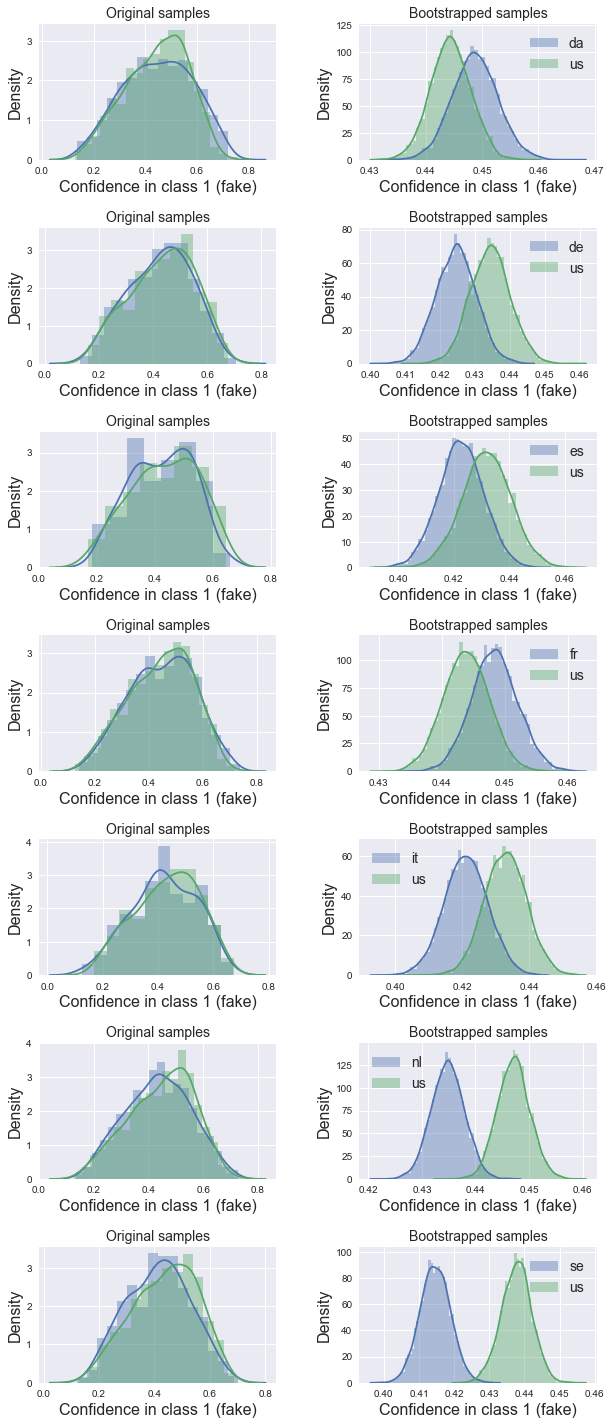

In [7]:
investigate_distributions("liar")

method = one vs US
method = one vs US
method = one vs US
method = one vs US
method = one vs US
method = one vs US
method = one vs US
da vs us all confidence in 1 scores bootstrap CI: (0.002555649104683755, 0.04830173331523757)
da mean= 0.8860987279090812  and SD= 0.008345647596111498
US mean= 0.8609369371412776  and SD= 0.00848630841052484
de vs us all confidence in 1 scores bootstrap CI: (-0.020031227906764704, 0.05030572434136582)
de mean= 0.8886872599247229  and SD= 0.01265234129936598
US mean= 0.8730943751190599  and SD= 0.013018772836644512
es vs us all confidence in 1 scores bootstrap CI: (-0.06038223854553082, 0.0538284704263684)
es mean= 0.8660421448757814  and SD= 0.020909731767910483
US mean= 0.8684525811018377  and SD= 0.02033353864327281
fr vs us all confidence in 1 scores bootstrap CI: (0.00909870869349394, 0.05447076683807239)
fr mean= 0.8927656701031174  and SD= 0.007879021626947863
US mean= 0.8606723968559902  and SD= 0.008637294995333254
it vs us all confidence in 1 sc

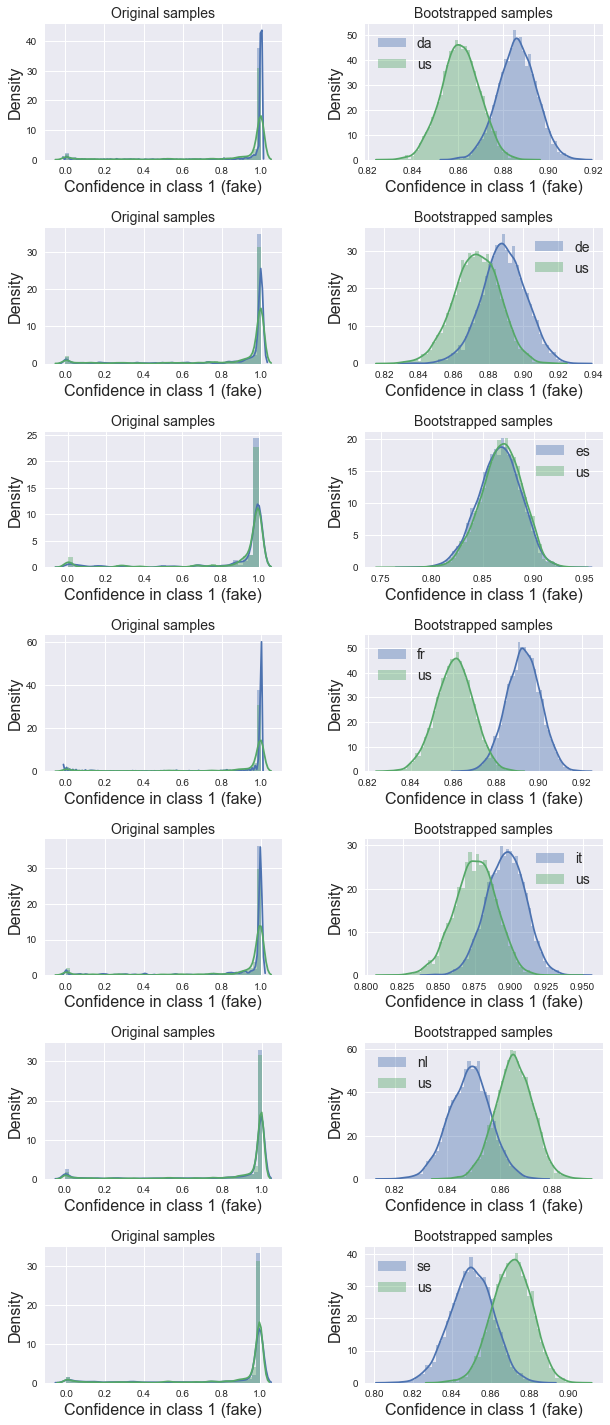

In [8]:
investigate_distributions("kaggle")

method = one vs US
method = one vs US
method = one vs US
method = one vs US
method = one vs US
method = one vs US
method = one vs US
da vs us all confidence in 1 scores bootstrap CI: (-0.040240582314677975, 0.011050639286051434)
da mean= 0.7105009147982553  and SD= 0.009321930003474572
US mean= 0.7250070188472311  and SD= 0.008586153305193212
de vs us all confidence in 1 scores bootstrap CI: (-0.09208028402782109, -0.01617507600882906)
de mean= 0.6737744830404199  and SD= 0.014381343129556419
US mean= 0.7278969584651206  and SD= 0.01334398951747605
es vs us all confidence in 1 scores bootstrap CI: (-0.0874404307525064, 0.03356085300534006)
es mean= 0.6796328795617498  and SD= 0.021626178935390164
US mean= 0.7072331047203048  and SD= 0.02189829822209967
fr vs us all confidence in 1 scores bootstrap CI: (-0.008829441642201008, 0.03848373395469995)
fr mean= 0.7408174105882246  and SD= 0.008535797296123611
US mean= 0.7258181486914878  and SD= 0.008674727603228691
it vs us all confidence in

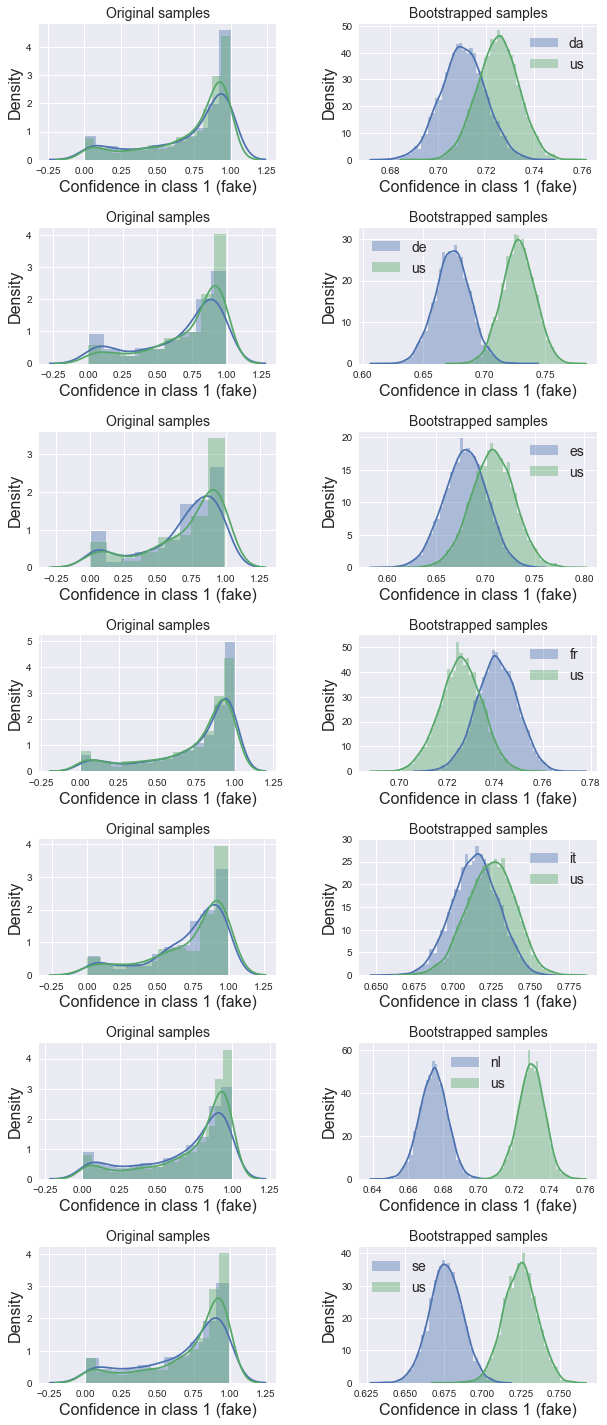

In [9]:
investigate_distributions("BS")

method = one vs US
method = one vs US
method = one vs US
method = one vs US
method = one vs US
method = one vs US
method = one vs US
da vs us confidence scores > 0.5 bootstrap CI: (-0.018981160603460223, 0.013638647528215642)
de vs us confidence scores > 0.5 bootstrap CI: (-0.009773973903957067, 0.04062717665680893)
es vs us confidence scores > 0.5 bootstrap CI: (0.0054160640599496546, 0.07453730490041166)
fr vs us confidence scores > 0.5 bootstrap CI: (-0.026811827392112964, 0.006637633053736103)
it vs us confidence scores > 0.5 bootstrap CI: (-0.034914918904382586, 0.020253682762535807)
nl vs us confidence scores > 0.5 bootstrap CI: (-0.017458928547725683, 0.011815817530311135)
se vs us confidence scores > 0.5 bootstrap CI: (-0.027505010200434055, 0.01154959929261068)


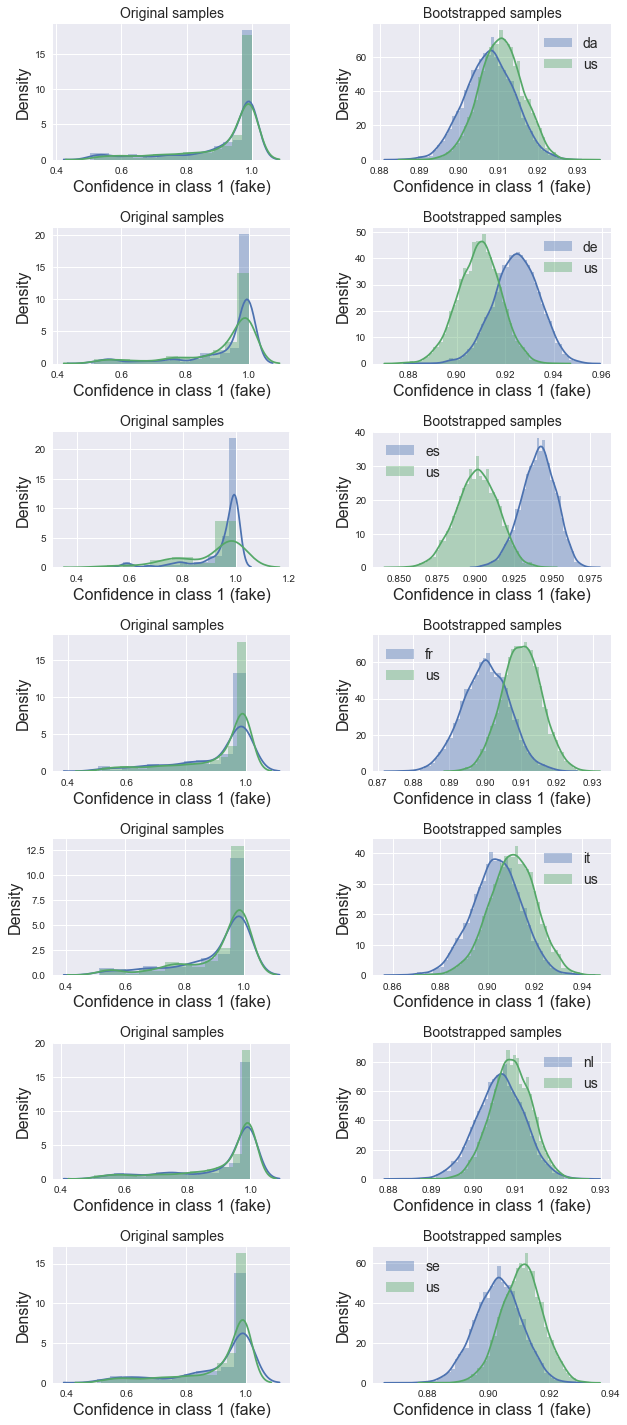

In [153]:
investigate_distributions("FNC")

method = one vs US
method = one vs US
method = one vs US
method = one vs US
method = one vs US
method = one vs US
method = one vs US
da vs us all confidence in 1 scores bootstrap CI: (-0.006175986158288349, 0.014618205800921491)
de vs us all confidence in 1 scores bootstrap CI: (-0.025623680353164646, 0.005807207191691699)
es vs us all confidence in 1 scores bootstrap CI: (-0.03263703413182795, 0.015348960234466247)
fr vs us all confidence in 1 scores bootstrap CI: (-0.005437853527487713, 0.014353613839131862)
it vs us all confidence in 1 scores bootstrap CI: (-0.02943577760172461, 0.006650579412897206)
nl vs us all confidence in 1 scores bootstrap CI: (-0.020808097897588973, -0.0038118194662669636)
se vs us all confidence in 1 scores bootstrap CI: (-0.035058167130166684, -0.01121975900348049)


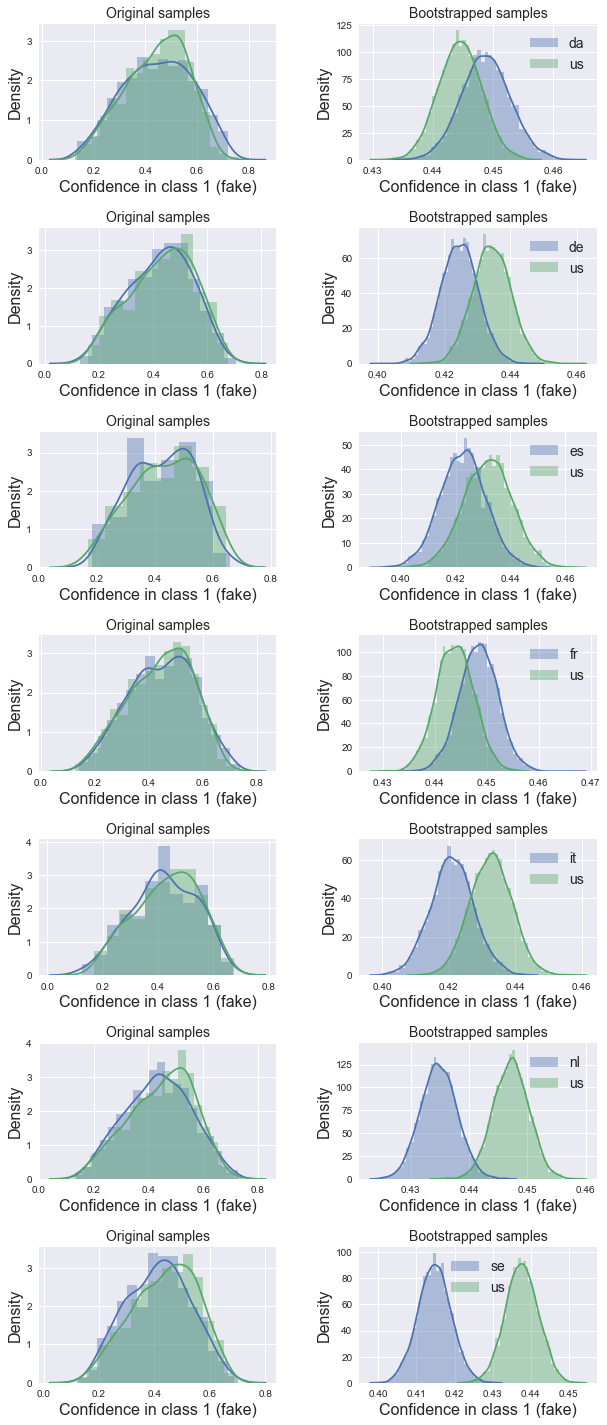

In [155]:
investigate_distributions("liar")

method = one vs US
method = one vs US
method = one vs US
method = one vs US
method = one vs US
method = one vs US
method = one vs US
da vs us all confidence in 1 scores bootstrap CI: (0.0012055747426525931, 0.049181617040266135)
de vs us all confidence in 1 scores bootstrap CI: (-0.020083064268071826, 0.05025065299798903)
es vs us all confidence in 1 scores bootstrap CI: (-0.05914511396922306, 0.0544631296656104)
fr vs us all confidence in 1 scores bootstrap CI: (0.007533536393394602, 0.05426332637074782)
it vs us all confidence in 1 scores bootstrap CI: (-0.017211901502210636, 0.060934757605641154)
nl vs us all confidence in 1 scores bootstrap CI: (-0.03745925982434528, 0.004117924227301506)
se vs us all confidence in 1 scores bootstrap CI: (-0.04973877951571315, 0.008970024810728172)


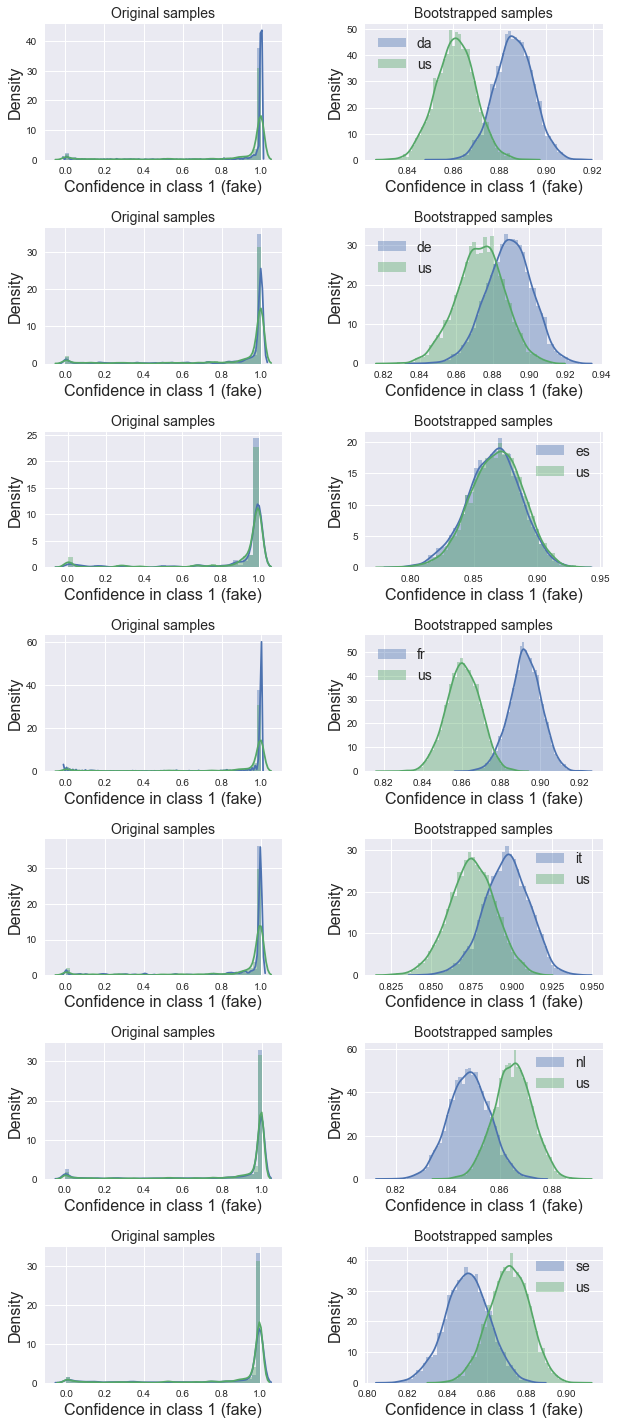

In [156]:
investigate_distributions("kaggle")

method = one vs US
method = one vs US
method = one vs US
method = one vs US
method = one vs US
method = one vs US
method = one vs US
da vs us all confidence in 1 scores bootstrap CI: (-0.039477067048676484, 0.011606415133441628)
de vs us all confidence in 1 scores bootstrap CI: (-0.09195494692498707, -0.013648986312396416)
es vs us all confidence in 1 scores bootstrap CI: (-0.08744689422352603, 0.03181450662083474)
fr vs us all confidence in 1 scores bootstrap CI: (-0.00886573163898352, 0.039002220927050746)
it vs us all confidence in 1 scores bootstrap CI: (-0.050948316803687166, 0.03196655236906798)
nl vs us all confidence in 1 scores bootstrap CI: (-0.07591894569983815, -0.03446354621457992)
se vs us all confidence in 1 scores bootstrap CI: (-0.07862652516673008, -0.018276961513882473)


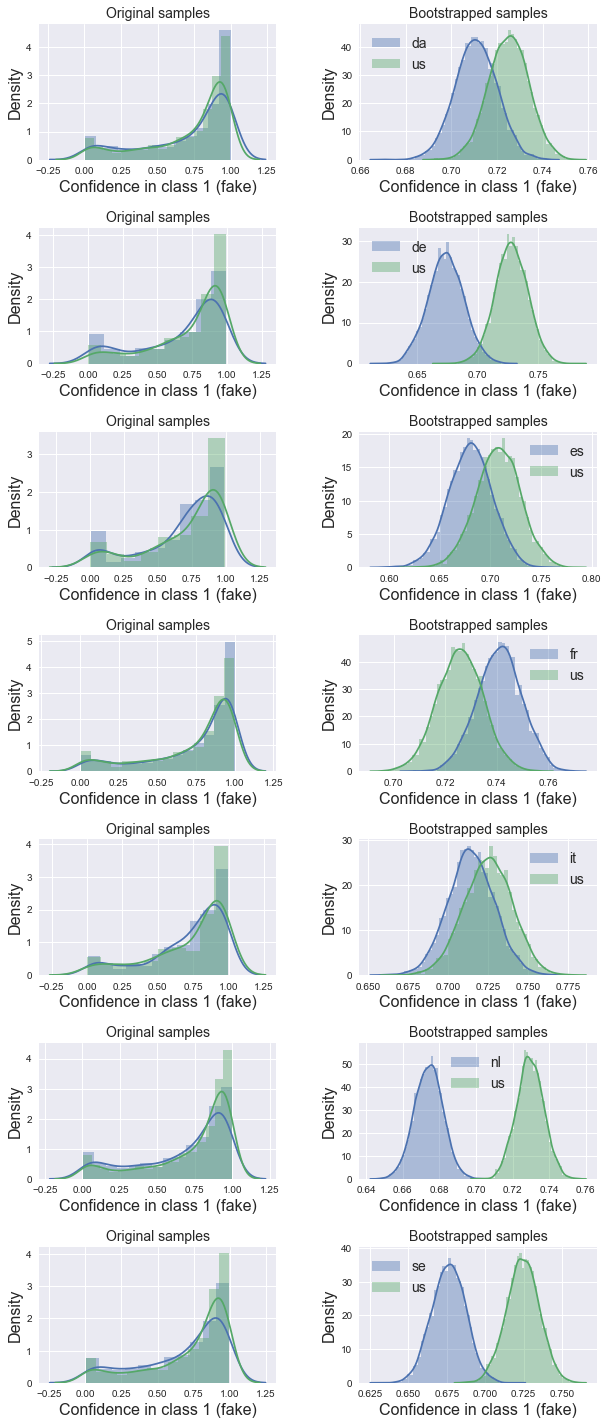

In [157]:
investigate_distributions("BS")

method = one vs US
method = one vs US
method = one vs US
method = one vs US
method = one vs US
method = one vs US
method = one vs US
da vs us all confidence in 1 scores bootstrap CI: (-0.10809269419392659, -0.03581681181926599)
de vs us all confidence in 1 scores bootstrap CI: (-0.1317165735380888, -0.015722629442497138)
es vs us all confidence in 1 scores bootstrap CI: (-0.13083453320874988, 0.047696994393852665)
fr vs us all confidence in 1 scores bootstrap CI: (-0.15169594262958186, -0.08019697742807896)
it vs us all confidence in 1 scores bootstrap CI: (-0.09656040836846874, 0.037118404240832015)
nl vs us all confidence in 1 scores bootstrap CI: (-0.15074201542095172, -0.08871691136042287)
se vs us all confidence in 1 scores bootstrap CI: (-0.11143317357882548, -0.021937733347444865)


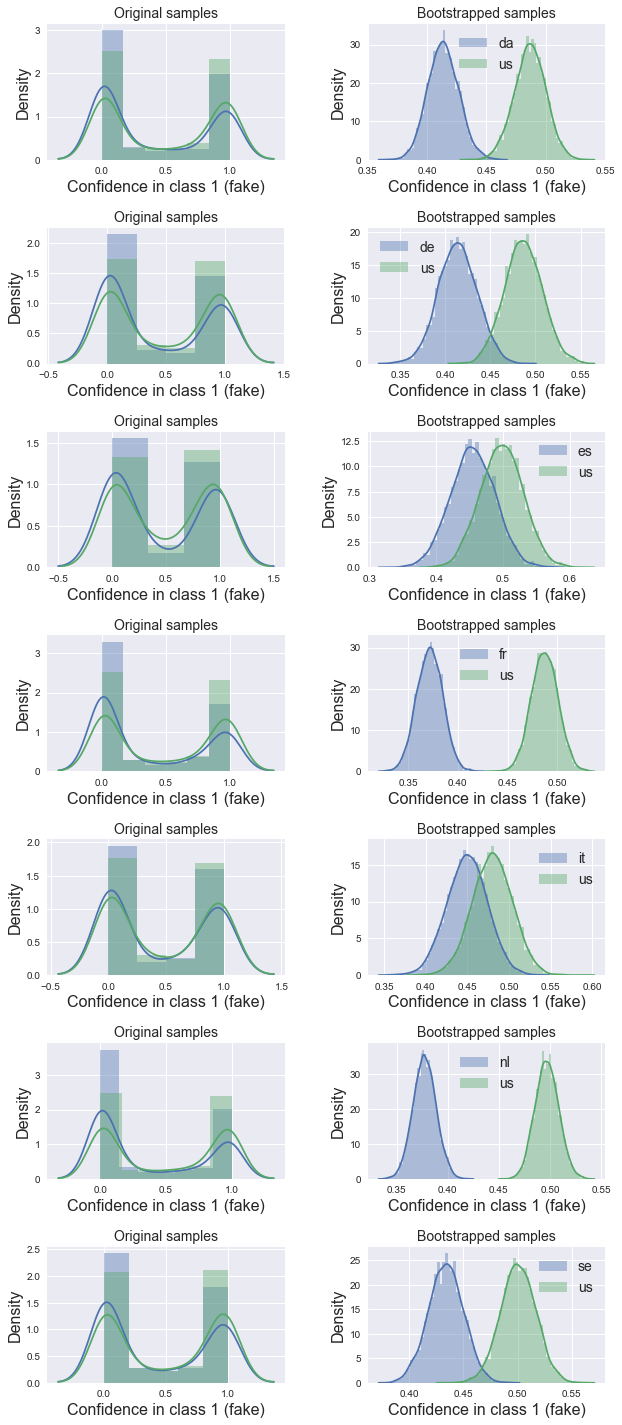

In [158]:
investigate_distributions("FNC")

In [182]:
def investigate_conf_distributions_all_vs_us(trainingdata, selection=None):
    #l = ["da", "de", "es", "fr", "it", "nl", "se"]
    df = get_all_vs_us_df(trainingdata)
    
    fig, ax = plt.subplots(1,2, figsize=(17,5))
    plt.subplots_adjust(hspace=0.5, wspace=0.35)
    
    if selection != None:
        conf1s_1 = df[(df.lang!="us")&(df.conf_1>selection)].conf_1
        conf1s_2 = df[(df.lang=="us")&(df.conf_1>selection)].conf_1
    else:
        conf1s_1 = df[df.lang!="us"].conf_1
        conf1s_2 = df[df.lang=="us"].conf_1
    
    sns.distplot(conf1s_1, label="Others", ax=ax[0])
    sns.distplot(conf1s_2, label="us", ax=ax[0])
    
    ci_diff, boot_d1, boot_d2 = bootci_diff(conf1s_1,conf1s_2, nboot=5000)
    print("Other locations vs us, all confidence in 1 scores bootstrap CI:", ci_diff)
    sns.distplot(boot_d1, label="Others", ax=ax[1])
    sns.distplot(boot_d2, label="us", ax=ax[1])
    ax[0].legend(fontsize=14)
    ax[0].set_xlabel("Confidence in class 1 (fake)", fontsize=16)
    ax[1].legend(fontsize=14)
    ax[1].set_xlabel("Confidence in class 1 (fake)", fontsize=16)
    ax[0].set_ylabel("Density", fontsize=16)
    ax[1].set_ylabel("Density", fontsize=16)
    ax[0].set_title("Original samples",fontsize=14)
    ax[1].set_title("Bootstrapped samples",fontsize=14)
    
    plt.savefig(trainingdata+"_conf_1_all_vs_us_threshold"+str(selection)+".png", dpi=100)
    sns.plt.show()

Other locations vs us, all confidence in 1 scores bootstrap CI: (-0.01796956278565448, -0.008875887272058236)


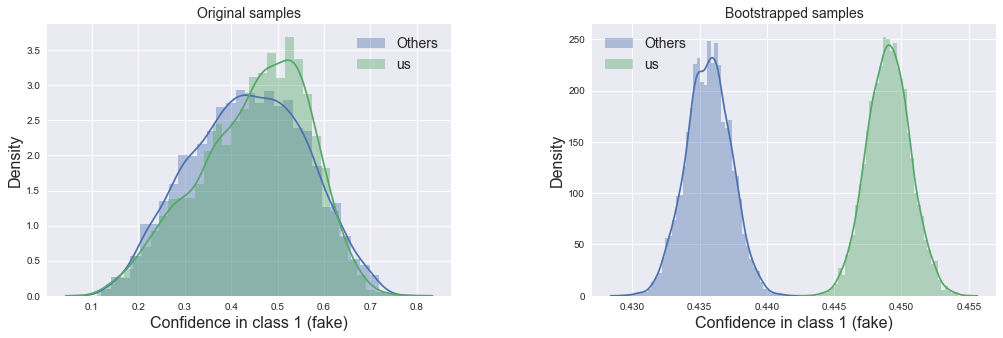

In [184]:
investigate_conf_distributions_all_vs_us("liar")

Other locations vs us, all confidence in 1 scores bootstrap CI: (0.005817418357737858, 0.012157775748011579)


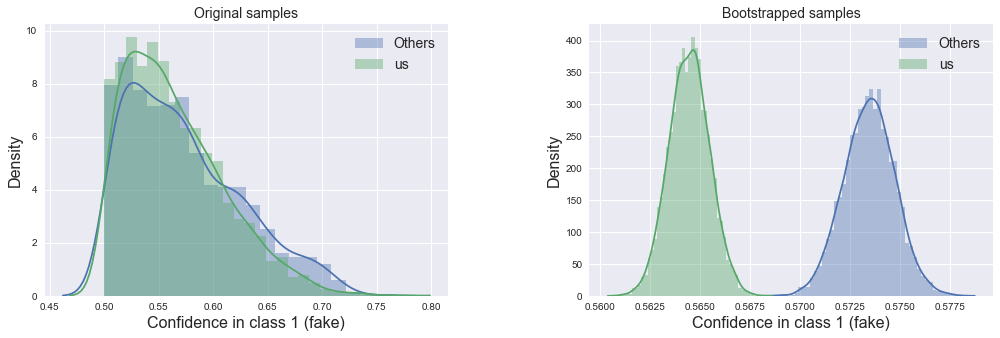

In [183]:
investigate_conf_distributions_all_vs_us("liar", selection=0.5)

Other locations vs us, all confidence in 1 scores bootstrap CI: (-0.006757959494029353, 0.014308090090638714)


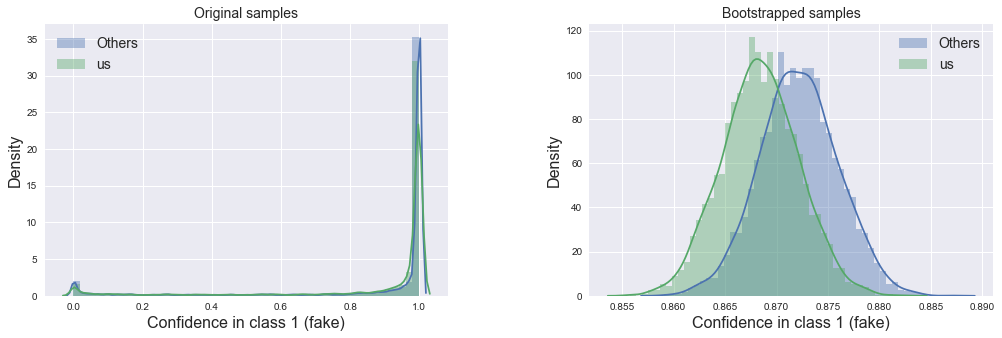

In [185]:
investigate_conf_distributions_all_vs_us("kaggle")

Other locations vs us, all confidence in 1 scores bootstrap CI: (0.004398132165759239, 0.01139239833713579)


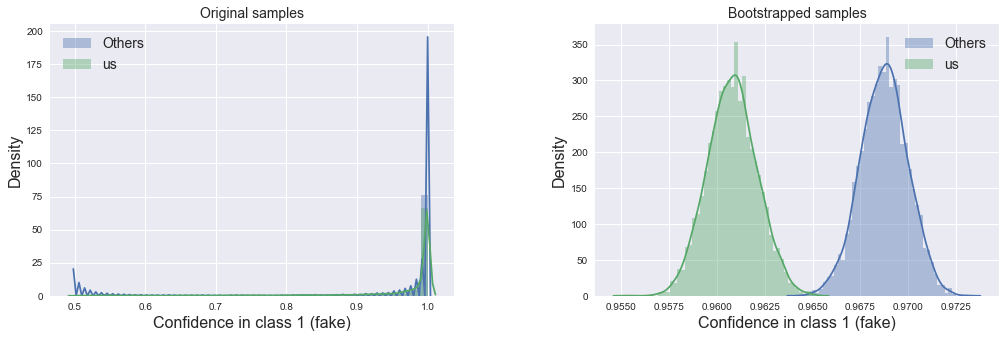

In [186]:
investigate_conf_distributions_all_vs_us("kaggle", selection=0.5)

Other locations vs us, all confidence in 1 scores bootstrap CI: (-0.0447392057583319, -0.022803996709231278)


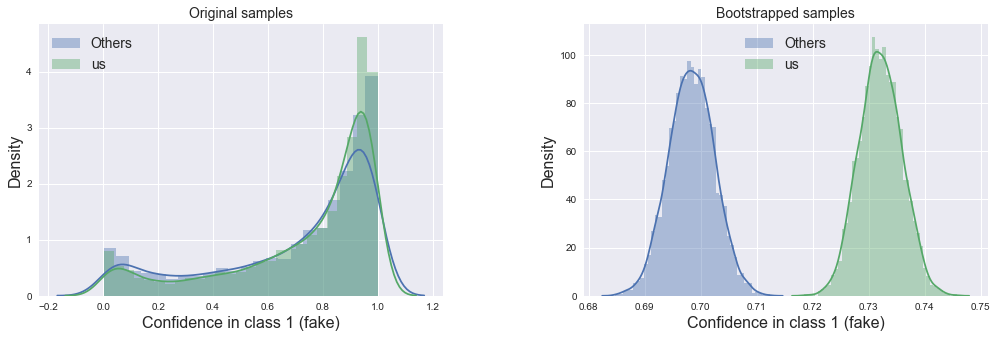

In [187]:
investigate_conf_distributions_all_vs_us("BS")

Other locations vs us, all confidence in 1 scores bootstrap CI: (-0.01201746966293582, -0.0009546559448410097)


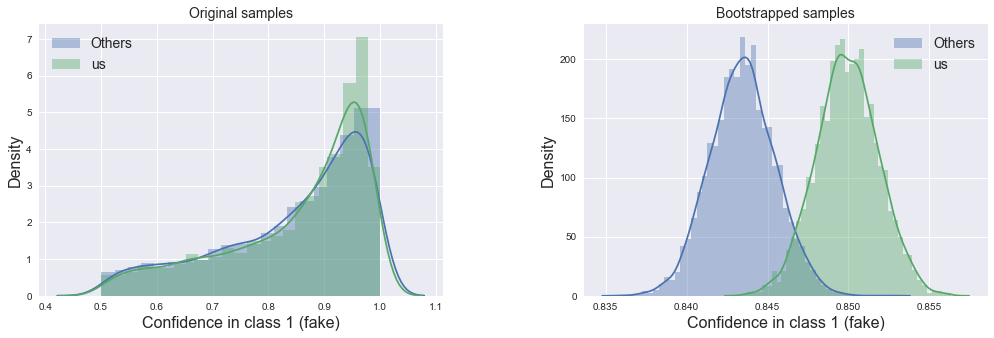

In [188]:
investigate_conf_distributions_all_vs_us("BS", selection=0.5)

Other locations vs us, all confidence in 1 scores bootstrap CI: (-0.10200520815761605, -0.06892801773751905)


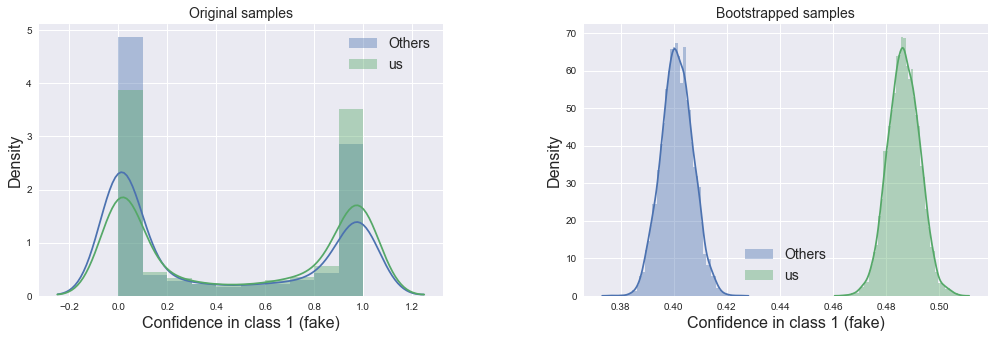

In [189]:
investigate_conf_distributions_all_vs_us("FNC")

Other locations vs us, all confidence in 1 scores bootstrap CI: (-0.01168988102048596, 0.003058024657285774)


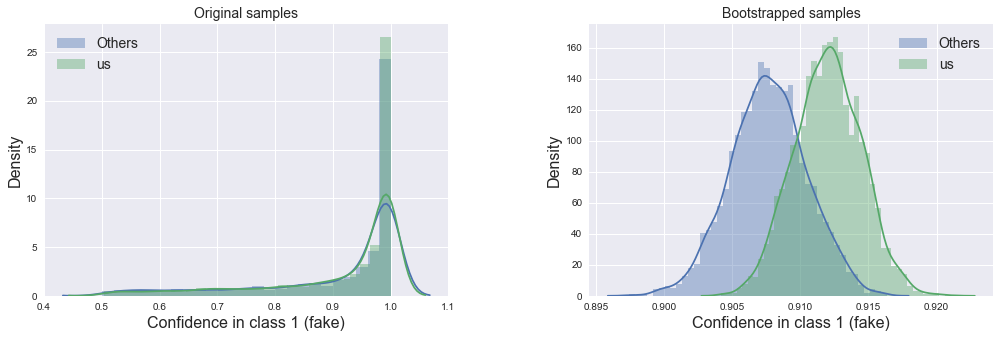

In [190]:
investigate_conf_distributions_all_vs_us("FNC", selection=0.5)

In [54]:
def make_confusion_matrix(tn,fp,fn,tp, title):
    sns.set_style('white')
    sns.set(rc={'figure.figsize':(11.7,8.27)})
    sns.set_context('paper', font_scale=1.8)
    #sns.set(font_scale=1.4)
    plt.rcParams["axes.labelsize"] = 13
    data = [[tn, fp],[fn, tp]]
    ax = sns.heatmap(data, annot=True, fmt="d")#annot_kws={"size": 14}
    #sns.heatmap(data, annot=True, fmt="d")
    ax.set(xlabel='Predicted class', ylabel='True class')
    plt.title(title, fontsize=14)
    plt.show()

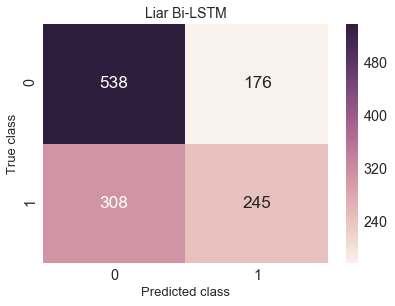

In [55]:
make_confusion_matrix(538,176,308,245, "Liar Bi-LSTM")

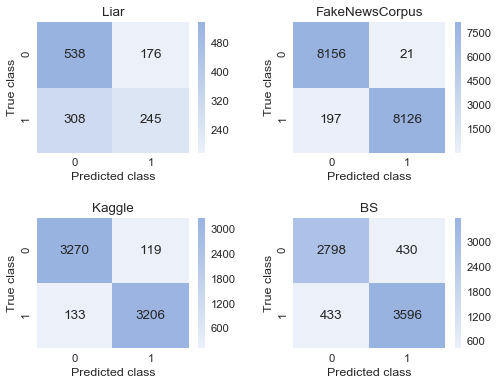

In [84]:
cmap = sns.light_palette((0.6,0.7,0.88), as_cmap=True)
#sns.choose_colorbrewer_palette("sequential", as_cmap=True)#sns.light_palette("Blue", as_cmap=True)#sns.color_palette("Blues")#sns.cubehelix_palette(rot=-.4, as_cmap=True)
#sns.palplot(sns.light_palette((0.83,0.99,0.86)))
fig, axes = plt.subplots(2,2, figsize=(8,6))
plt.subplots_adjust(hspace=0.5, wspace=0.35)
liar = [[538,176],[308,245]]
FNC = [[8156, 21], [197,8126]]
Kaggle = [[3270,119],[133,3206]]
BS = [[2798,430],[433,3596]]
data = [liar,FNC, Kaggle, BS]
titles = ["Liar", "FakeNewsCorpus", "Kaggle", "BS"]
#axes.set(xlabel='Predicted class', ylabel='True class')
for i, (d, t) in enumerate(zip(data,titles)):
    #sns.set_style('white')
    #sns.set(rc={'figure.figsize':(20,20)})
    sns.set_context('paper', font_scale=1.4)
    sns.heatmap(d, annot=True, fmt="d", ax=axes.flat[i], cmap=cmap)
    axes.flat[i].set_ylabel('True class')
    axes.flat[i].set_xlabel('Predicted class')
    axes.flat[i].set_title(t)
plt.savefig("test_confusion_matrices.png", dpi=150, bbox_inches='tight')

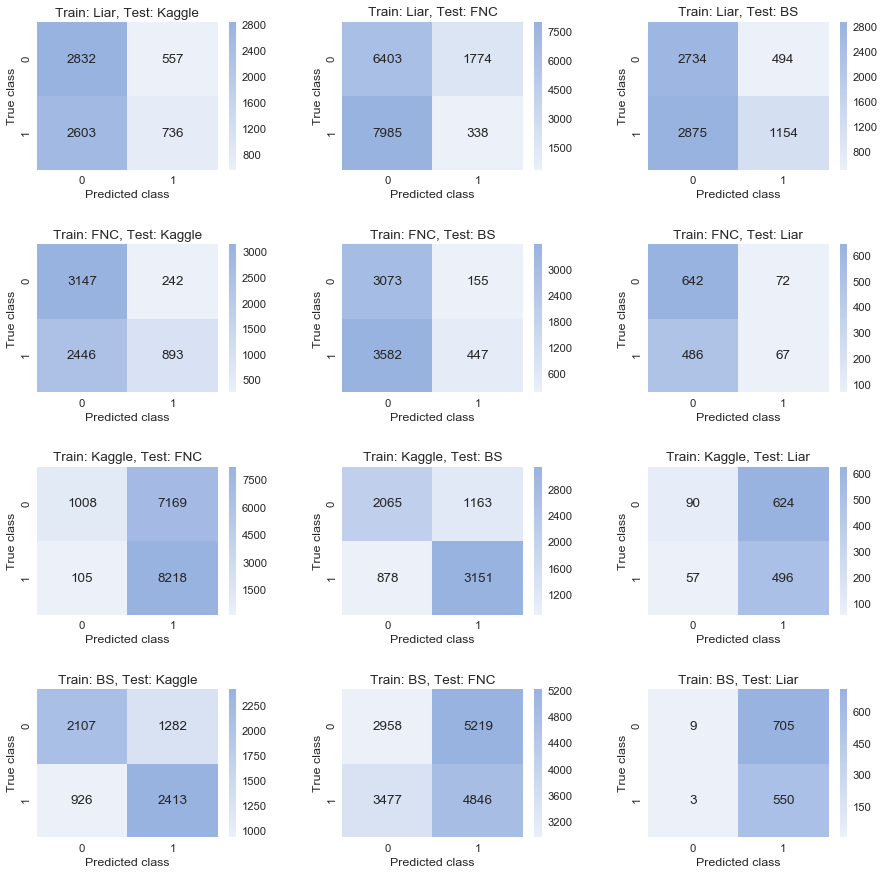

In [8]:
cmap = sns.light_palette((0.6,0.7,0.88), as_cmap=True)
#sns.choose_colorbrewer_palette("sequential", as_cmap=True)#sns.light_palette("Blue", as_cmap=True)#sns.color_palette("Blues")#sns.cubehelix_palette(rot=-.4, as_cmap=True)
#sns.palplot(sns.light_palette((0.83,0.99,0.86)))
fig, axes = plt.subplots(4,3, figsize=(15,15))
plt.subplots_adjust(hspace=0.5, wspace=0.35)
#liar = [[538,176],[308,245]]
#FNC = [[8156, 21], [197,8126]]
#Kaggle = [[3270,119],[133,3206]]
#BS = [[2798,430],[433,3596]]
liar_kaggle = [[2832, 557], [2603, 736]]
liar_FNC = [[6403,1774],[7985,338]]
liar_BS = [[2734,494],[2875,1154]]

kaggle_FNC = [[1008,7169],[105,8218]]
kaggle_BS = [[2065,1163],[878,3151]]
kaggle_liar = [[90,624],[57,496]]

BS_kaggle = [[2107,1282],[926,2413]]
BS_FNC = [[2958,5219],[3477,4846]]
BS_liar = [[9,705],[3,550]]

FNC_kaggle = [[3147,242],[2446,893]]
FNC_BS = [[3073,155],[3582,447]]
FNC_liar = [[642,72],[486,67]]

data = [liar_kaggle, liar_FNC, liar_BS,  
        FNC_kaggle, FNC_BS, FNC_liar, 
        kaggle_FNC, kaggle_BS, kaggle_liar, 
        BS_kaggle, BS_FNC, BS_liar]


titles = ["Train: Liar, Test: Kaggle","Train: Liar, Test: FNC", "Train: Liar, Test: BS",
          "Train: FNC, Test: Kaggle", "Train: FNC, Test: BS", "Train: FNC, Test: Liar", 
          "Train: Kaggle, Test: FNC", "Train: Kaggle, Test: BS", "Train: Kaggle, Test: Liar", 
          "Train: BS, Test: Kaggle", "Train: BS, Test: FNC", "Train: BS, Test: Liar"]
#axes.set(xlabel='Predicted class', ylabel='True class')
for i, (d, t) in enumerate(zip(data,titles)):
    #sns.set_style('white')
    #sns.set(rc={'figure.figsize':(20,20)})
    sns.set_context('paper', font_scale=1.4)
    sns.heatmap(d, annot=True, fmt="d", ax=axes.flat[i], cmap=cmap)
    axes.flat[i].set_ylabel('True class')
    axes.flat[i].set_xlabel('Predicted class')
    axes.flat[i].set_title(t)
plt.savefig("cross_corpora_confusion_matrices.png", dpi=70, bbox_inches='tight')